# SPACEL workflow (1/3): Deconvolution by Spoint on mouse brain ST dataset

July 2023

Dataset: 75 ST slices of mouse brain ([here](https://zenodo.org/record/8167488))

In [3]:
import sys
sys.path.append('/data/wzh/SPACEL-l')

In [4]:
import pandas as pd
import scanpy as sc
import anndata
import os
from tqdm import tqdm 
import scanpy as sc
import numpy as np
import sys

## Load spatial transcriptomics data

The input data are anndata objects stored raw counts for scRNA-seq and ST. The scRNA-seq anndata must have cell type annotation in ``.obs``.

In [23]:
adata = sc.read('/data/KanCell-main/docs/data/visium_human_breast_cancer/Spatial1.h5ad')
scadata = sc.read_h5ad('/data/KanCell-main/docs/data/visium_human_breast_cancer/scRNA.h5ad')

In [24]:
scadata.var_names_make_unique()
scadata.obs_names_make_unique()

In [25]:
scadata

AnnData object with n_obs × n_vars = 3977 × 15433
    obs: 'CellType'
    var: 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [26]:
scadata.obs['CellType']

CELL_CID3921_AAAGATGGTGAGGCTA     TYPE_Endothelial cells
CELL_CID3921_AAAGATGTCCATGAGT     TYPE_Endothelial cells
CELL_CID3921_AACCATGCAGTAACGG     TYPE_Endothelial cells
CELL_CID3921_AACCGCGGTCAGAATA     TYPE_Endothelial cells
CELL_CID3921_AACGTTGTCAGCTGGC     TYPE_Endothelial cells
                                           ...          
CELL_CID45171_CTGCTGTTCCTTTCGG     TYPE_Epithelial cells
CELL_CID3921_TCTTTCCTCCGAACGC      TYPE_Epithelial cells
CELL_CID45171_TATTACCTCGACCAGC     TYPE_Epithelial cells
CELL_CID3921_CTCATTATCTGTCTAT      TYPE_Epithelial cells
CELL_CID3921_GATCGTACACAGATTC      TYPE_Epithelial cells
Name: CellType, Length: 3977, dtype: category
Categories (11, object): ['TYPE_B cells', 'TYPE_Dendritic cells', 'TYPE_Endothelial cells', 'TYPE_Epithelial cells', ..., 'TYPE_PCs', 'TYPE_PVL', 'TYPE_T cells CD4', 'TYPE_T cells CD8']

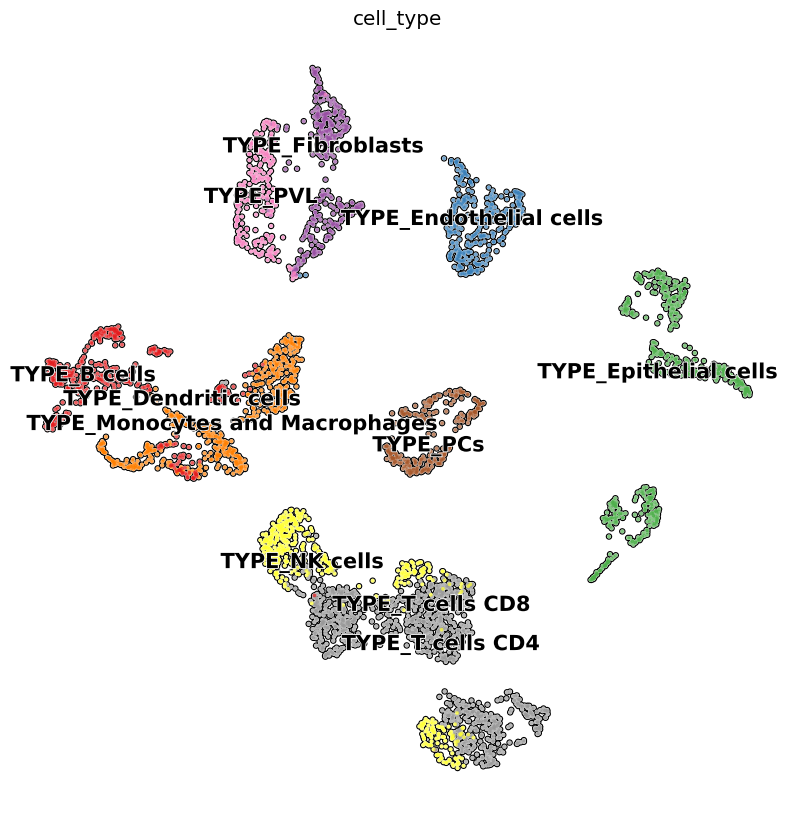

In [40]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
sc.pp.neighbors(scadata, n_pcs=50)
sc.tl.umap(scadata)
with plt.rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(scadata, color='CellType', add_outline=True, legend_loc='on data',title='cell_type',
               legend_fontsize=15, legend_fontoutline=1.2, frameon=False,
                palette='Set1',size=30)

## Initialize and train the Spoint model

In this step, we initialize the Spoint model using anndata objects for scRNA-seq and ST as input. The``celltype_key`` parameter represents the column name of the cell type annotation in the .obs attribute of the scRNA-seq anndata object. The ``sm_size`` parameter controls the number of simulated spots, and it is important to have a sufficient ``sm_size`` for accurate prediction. However, it should be noted that increasing the ``sm_size`` will also increase the simulation and training time. In general, we recommend setting ``sm_size`` to a value greater than 100,000.

In [11]:
import KanCell
from KanCell.setting import set_environ_seed
set_environ_seed()
from KanCell import Spoint

Setting environment seed: 42


Global seed set to 0
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
spoint_model = Spoint.init_model(scadata,adata,celltype_key='CellType',sm_size=500000,use_gpu=True,n_threads=16)

Setting global seed: 42
### Finding marker genes...
CellType
TYPE_B cells                      200
TYPE_Dendritic cells              200
TYPE_Endothelial cells            200
TYPE_Epithelial cells             200
TYPE_Fibroblasts                  200
TYPE_Monocytes and Macrophages    200
TYPE_NK cells                     200
TYPE_PVL                          200
TYPE_T cells CD4                  200
TYPE_T cells CD8                  200
TYPE_PCs                          140
Name: count, dtype: int64
### Used gene numbers: 1764
### Initializing sample probability
### Genetating simulated spatial data using scRNA data with mode: unbalance
### Genetating simulated spatial data using scRNA data with mode: sqrt
### Genetating simulated spatial data using scRNA data with mode: balance


In [14]:
import os,sys
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
spoint_model.train(max_steps=5000, batch_size=1024)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/100:   1%|          | 1/100 [00:09<16:06,  9.76s/it, loss=2.16e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/100:   2%|▏         | 2/100 [00:19<15:38,  9.58s/it, loss=2.1e+03, v_num=1] 

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/100:   3%|▎         | 3/100 [00:28<15:21,  9.50s/it, loss=2.07e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/100:   4%|▍         | 4/100 [00:37<15:04,  9.43s/it, loss=2.04e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/100:   5%|▌         | 5/100 [00:47<14:46,  9.33s/it, loss=2.02e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/100:   6%|▌         | 6/100 [00:56<14:39,  9.35s/it, loss=2.01e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/100:   7%|▋         | 7/100 [01:05<14:32,  9.38s/it, loss=1.99e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/100:   8%|▊         | 8/100 [01:15<14:23,  9.39s/it, loss=1.98e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/100:   9%|▉         | 9/100 [01:24<14:14,  9.39s/it, loss=1.97e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/100:  10%|█         | 10/100 [01:34<14:05,  9.39s/it, loss=1.96e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 12/100:  11%|█         | 11/100 [01:43<13:56,  9.40s/it, loss=1.95e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 13/100:  12%|█▏        | 12/100 [01:52<13:47,  9.40s/it, loss=1.95e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 14/100:  13%|█▎        | 13/100 [02:02<13:37,  9.40s/it, loss=1.94e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/100:  14%|█▍        | 14/100 [02:11<13:28,  9.40s/it, loss=1.93e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 16/100:  15%|█▌        | 15/100 [02:21<13:18,  9.40s/it, loss=1.93e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 17/100:  16%|█▌        | 16/100 [02:30<13:10,  9.41s/it, loss=1.92e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 18/100:  17%|█▋        | 17/100 [02:39<13:00,  9.40s/it, loss=1.91e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 19/100:  18%|█▊        | 18/100 [02:49<12:53,  9.43s/it, loss=1.91e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/100:  19%|█▉        | 19/100 [02:58<12:45,  9.46s/it, loss=1.9e+03, v_num=1] 

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 21/100:  20%|██        | 20/100 [03:08<12:35,  9.44s/it, loss=1.9e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 22/100:  21%|██        | 21/100 [03:17<12:24,  9.42s/it, loss=1.9e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 23/100:  22%|██▏       | 22/100 [03:27<12:15,  9.43s/it, loss=1.89e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 24/100:  23%|██▎       | 23/100 [03:36<12:05,  9.42s/it, loss=1.89e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/100:  24%|██▍       | 24/100 [03:45<11:52,  9.37s/it, loss=1.89e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 26/100:  25%|██▌       | 25/100 [03:54<11:37,  9.30s/it, loss=1.89e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 27/100:  26%|██▌       | 26/100 [04:04<11:24,  9.25s/it, loss=1.88e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 28/100:  27%|██▋       | 27/100 [04:13<11:12,  9.21s/it, loss=1.88e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 29/100:  28%|██▊       | 28/100 [04:22<11:02,  9.21s/it, loss=1.88e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 30/100:  29%|██▉       | 29/100 [04:31<10:57,  9.26s/it, loss=1.87e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 31/100:  30%|███       | 30/100 [04:41<10:48,  9.27s/it, loss=1.87e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 32/100:  31%|███       | 31/100 [04:50<10:36,  9.22s/it, loss=1.87e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 33/100:  32%|███▏      | 32/100 [04:59<10:21,  9.14s/it, loss=1.87e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 34/100:  33%|███▎      | 33/100 [05:08<10:08,  9.08s/it, loss=1.87e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 35/100:  34%|███▍      | 34/100 [05:17<09:56,  9.04s/it, loss=1.87e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 36/100:  35%|███▌      | 35/100 [05:26<09:45,  9.01s/it, loss=1.87e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 37/100:  36%|███▌      | 36/100 [05:34<09:34,  8.97s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 38/100:  37%|███▋      | 37/100 [05:43<09:25,  8.97s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 39/100:  38%|███▊      | 38/100 [05:54<09:42,  9.40s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 40/100:  39%|███▉      | 39/100 [06:05<10:04,  9.90s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 41/100:  40%|████      | 40/100 [06:14<09:44,  9.74s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 42/100:  41%|████      | 41/100 [06:24<09:27,  9.63s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 43/100:  42%|████▏     | 42/100 [06:33<09:13,  9.55s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 44/100:  43%|████▎     | 43/100 [06:42<09:01,  9.50s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 45/100:  44%|████▍     | 44/100 [06:52<08:50,  9.47s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 46/100:  45%|████▌     | 45/100 [07:01<08:39,  9.44s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 47/100:  46%|████▌     | 46/100 [07:10<08:28,  9.42s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 48/100:  47%|████▋     | 47/100 [07:20<08:18,  9.40s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 49/100:  48%|████▊     | 48/100 [07:29<08:08,  9.39s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 50/100:  49%|████▉     | 49/100 [07:39<07:58,  9.38s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 51/100:  50%|█████     | 50/100 [07:48<07:48,  9.38s/it, loss=1.86e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 52/100:  51%|█████     | 51/100 [07:57<07:39,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 53/100:  52%|█████▏    | 52/100 [08:07<07:29,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 54/100:  53%|█████▎    | 53/100 [08:16<07:20,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 55/100:  54%|█████▍    | 54/100 [08:25<07:10,  9.36s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 56/100:  55%|█████▌    | 55/100 [08:35<07:01,  9.36s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 57/100:  56%|█████▌    | 56/100 [08:44<06:52,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 58/100:  57%|█████▋    | 57/100 [08:53<06:42,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 59/100:  58%|█████▊    | 58/100 [09:03<06:33,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 60/100:  59%|█████▉    | 59/100 [09:12<06:23,  9.36s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 61/100:  60%|██████    | 60/100 [09:22<06:14,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 62/100:  61%|██████    | 61/100 [09:31<06:05,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 63/100:  62%|██████▏   | 62/100 [09:40<05:56,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 64/100:  63%|██████▎   | 63/100 [09:50<05:46,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 65/100:  64%|██████▍   | 64/100 [09:59<05:37,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 66/100:  65%|██████▌   | 65/100 [10:08<05:28,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 67/100:  66%|██████▌   | 66/100 [10:18<05:18,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 68/100:  67%|██████▋   | 67/100 [10:27<05:10,  9.39s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 69/100:  68%|██████▊   | 68/100 [10:37<04:59,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 70/100:  69%|██████▉   | 69/100 [10:46<04:46,  9.25s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 71/100:  70%|███████   | 70/100 [10:55<04:35,  9.18s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 72/100:  71%|███████   | 71/100 [11:04<04:26,  9.20s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 73/100:  72%|███████▏  | 72/100 [11:13<04:15,  9.14s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 74/100:  73%|███████▎  | 73/100 [11:22<04:05,  9.09s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 75/100:  74%|███████▍  | 74/100 [11:31<03:55,  9.06s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 76/100:  75%|███████▌  | 75/100 [11:40<03:45,  9.03s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 77/100:  76%|███████▌  | 76/100 [11:49<03:38,  9.09s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 78/100:  77%|███████▋  | 77/100 [11:58<03:30,  9.16s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 79/100:  78%|███████▊  | 78/100 [12:08<03:22,  9.21s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 80/100:  79%|███████▉  | 79/100 [12:17<03:11,  9.14s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 81/100:  80%|████████  | 80/100 [12:26<03:03,  9.19s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 82/100:  81%|████████  | 81/100 [12:35<02:55,  9.26s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 83/100:  82%|████████▏ | 82/100 [12:45<02:47,  9.30s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 84/100:  83%|████████▎ | 83/100 [12:54<02:38,  9.33s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 85/100:  84%|████████▍ | 84/100 [13:03<02:29,  9.33s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 86/100:  85%|████████▌ | 85/100 [13:13<02:19,  9.31s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 87/100:  86%|████████▌ | 86/100 [13:22<02:10,  9.30s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 88/100:  87%|████████▋ | 87/100 [13:31<02:00,  9.28s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 89/100:  88%|████████▊ | 88/100 [13:41<01:52,  9.34s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 90/100:  89%|████████▉ | 89/100 [13:50<01:43,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 91/100:  90%|█████████ | 90/100 [13:59<01:33,  9.37s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 92/100:  91%|█████████ | 91/100 [14:09<01:24,  9.38s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 93/100:  92%|█████████▏| 92/100 [14:18<01:15,  9.42s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 94/100:  93%|█████████▎| 93/100 [14:28<01:05,  9.40s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 95/100:  94%|█████████▍| 94/100 [14:37<00:56,  9.39s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 96/100:  95%|█████████▌| 95/100 [14:46<00:46,  9.36s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 97/100:  96%|█████████▌| 96/100 [14:56<00:37,  9.33s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 98/100:  97%|█████████▋| 97/100 [15:05<00:27,  9.31s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 99/100:  98%|█████████▊| 98/100 [15:14<00:18,  9.30s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/100:  99%|█████████▉| 99/100 [15:24<00:09,  9.33s/it, loss=1.85e+03, v_num=1]

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/100: 100%|██████████| 100/100 [15:33<00:00,  9.35s/it, loss=1.85e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [15:33<00:00,  9.34s/it, loss=1.85e+03, v_num=1]


Step 5000: Test inference loss=-0.961: 100%|██████████| 5000/5000 [44:53<00:00,  1.86it/s]


Then, we utilize the trained model to predict the cell type composition of each spot in the spatial transcriptomics data. This prediction will generate a DataFrame object, where each row corresponds to a spot in the spatial transcriptomics data, each column represents a cell type from the single-cell RNA-seq data, and each entry indicates the proportion of a particular cell type in a spot. Additionally, we can obtain the anndata object of the spatial transcriptomics data with the deconvolution results embedded in the .obs attribute.

In [15]:
pre = spoint_model.deconv_spatial()
st_ad = spoint_model.st_ad
# st_ad.write('../data/ST_mouse_brain/mouse_brain_st.h5ad')

## Visualization results

As a demonstration, we plotted the predicted compositions of cell types on a slice, where the cell types are selected as the top 20 with the highest proportion within each spot.

In [16]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=50,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3

In [18]:
# st_ad = st_ad[st_ad.obs.slice==37]
celltype = st_ad.obs.loc[:,pre.columns].max(0)

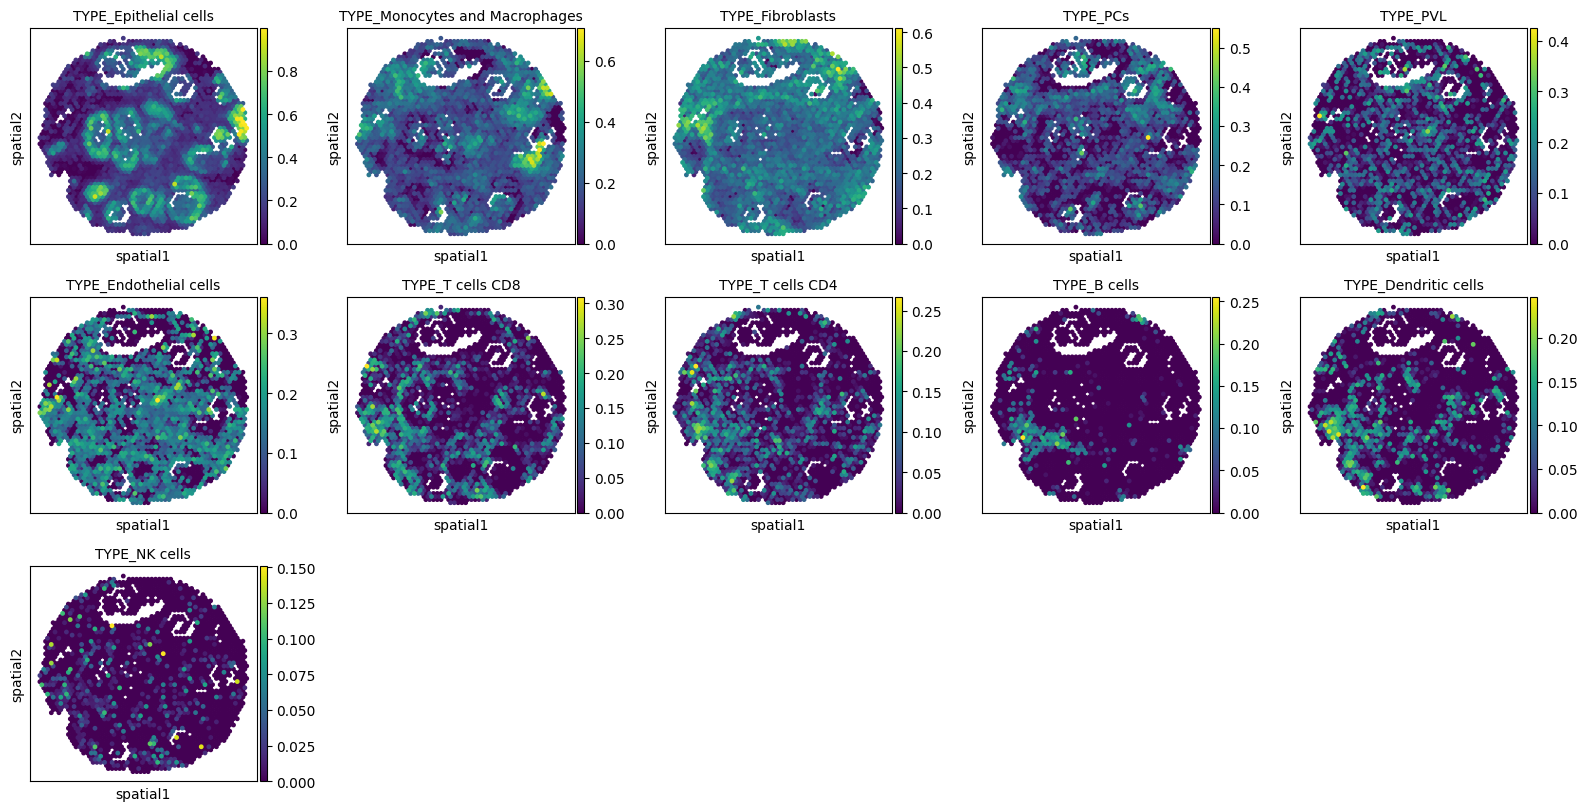

In [19]:
sc.pl.embedding(st_ad,color=celltype.sort_values(ascending=False)[:20].index,basis='spatial',ncols=5)

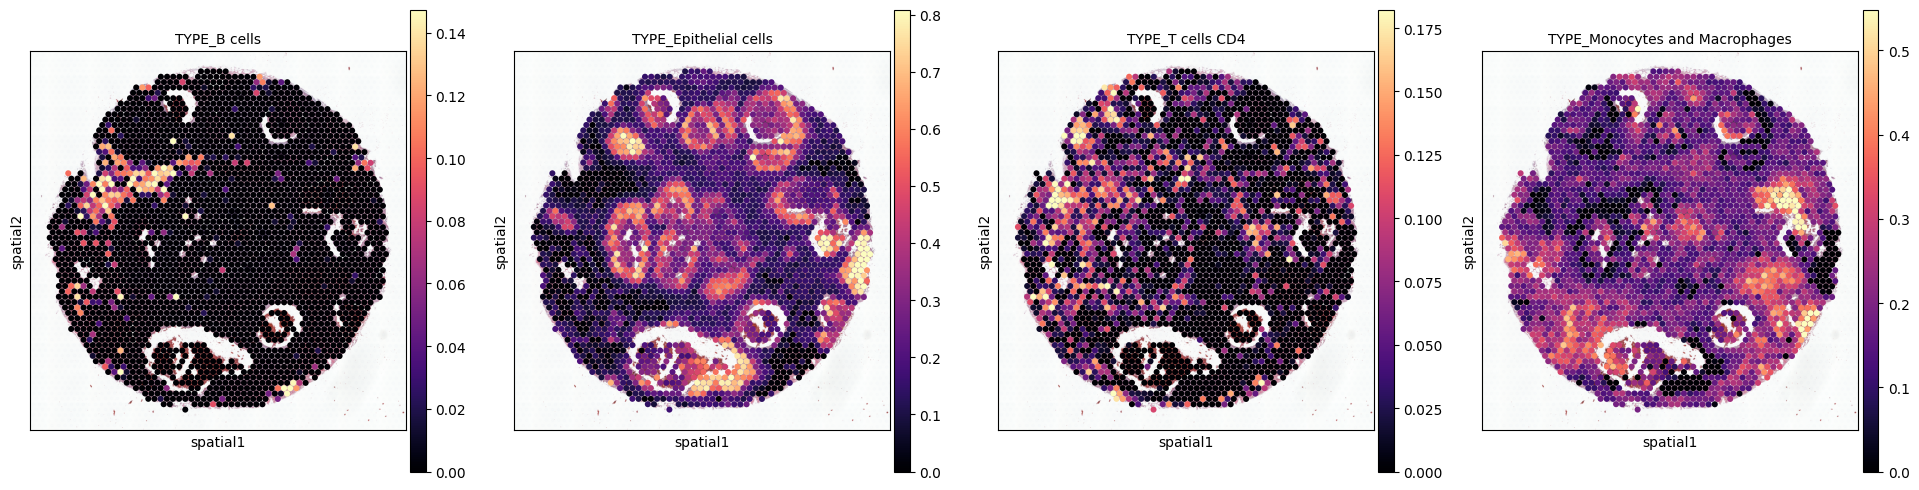

In [24]:
# Visualization of spatial distribution of scRNA-seq data   scRNA-seq 数据空间分布的可视化
import matplotlib as mpl
import matplotlib.pyplot as plt
with mpl.rc_context({'axes.facecolor':'white',
                     'figure.figsize': [5, 6]}):

                        sc.pl.spatial(st_ad, cmap='magma',
                                # selected cell types
                                color=['TYPE_B cells',  'TYPE_Epithelial cells', 'TYPE_T cells CD4', 'TYPE_Monocytes and Macrophages'],
                                ncols=5, size=1.5,
                                img_key='hires',
                                # limit color scale at 99.2% quantile of cell abundance
                                vmin=0, vmax='p99.2',
                                show=True
                 )

In [35]:
st_ad

AnnData object with n_obs × n_vars = 2518 × 1764
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'batch', 'TYPE_T cells CD4', 'TYPE_Monocytes and Macrophages', 'TYPE_Epithelial cells', 'TYPE_T cells CD8', 'TYPE_NK cells', 'TYPE_Fibroblasts', 'TYPE_Endothelial cells', 'TYPE_B cells', 'TYPE_PVL', 'TYPE_PCs', 'TYPE_Dendritic cells'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'log1p', 'spatial', 'celltypes'
    obsm: 'spatial'
    layers: 'norm'

In [38]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
    "0": "TYPE_T cells CD4",
    "1": "TYPE_Monocytes and Macrophages",
    "2": "TYPE_Epithelial cells",
    "3": "TYPE_T cells CD8",
    "4": "TYPE_NK cells",
    "5": "TYPE_Fibroblasts",
    "6": "TYPE_Endothelial cells",
    "7": "TYPE_B cells",
    "8": "TYPE_PVL",
    "9": "TYPE_Dendritic cells",
    "10": "TYPE_PCs",
}

In [44]:
adata

AnnData object with n_obs × n_vars = 2518 × 15433
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial'
    layers: 'norm'

In [61]:
scadata

AnnData object with n_obs × n_vars = 3977 × 15433
    obs: 'CellType', 'clusters'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'CellType_colors', 'clusters', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'norm'
    obsp: 'distances', 'connectivities'

In [ ]:
marker_genes_dict = {
    "TYPE_T cells CD4": ["0"],
    "TYPE_Monocytes and Macrophages": ["1"],
    "TYPE_Epithelial cells": ["2"],
    "TYPE_T cells CD8": ["3"],
    "TYPE_NK cells": ["4"],
    "TYPE_Fibroblasts": ["5"],
    "TYPE_Endothelial cells": ["6"],
    "TYPE_B cells": ["7"],
    "TYPE_PVL": ["8"],
    "TYPE_Dendritic cells": ["9"],
    "TYPE_PCs": ["10"],
}

categories: TYPE_B cells, TYPE_Dendritic cells, TYPE_Endothelial cells, etc.
var_group_labels: 0, 1, 2, etc.


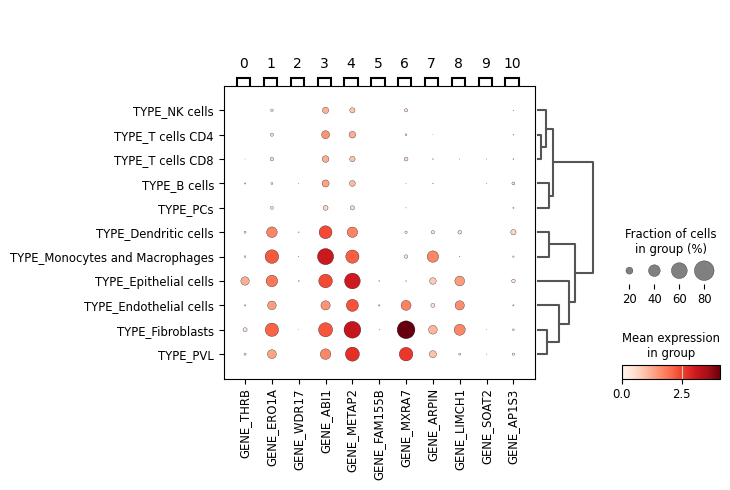

In [77]:
# 更新 marker_genes_dict 以使用实际的基因标记名称
marker_genes_dict = {
    "0": ["GENE_THRB"],  # 示例基因标记
    "1": ["GENE_ERO1A"],
    "2": ["GENE_WDR17"],
    "3": ["GENE_ABI1"],
    "4": ["GENE_METAP2"],
    "5": ["GENE_FAM155B"],
    "6": ["GENE_MXRA7"],
    "7": ["GENE_ARPIN"],
    "8": ["GENE_LIMCH1"],
    "9": ["GENE_SOAT2"],
    "10": ["GENE_AP1S3"],
}

# 绘制 dotplot
import scanpy as sc
sc.pl.dotplot(scadata, marker_genes_dict, groupby="CellType", dendrogram=True)


In [112]:
sc_adata = sc.read_h5ad('/data/wzh/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
ranking genes


/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


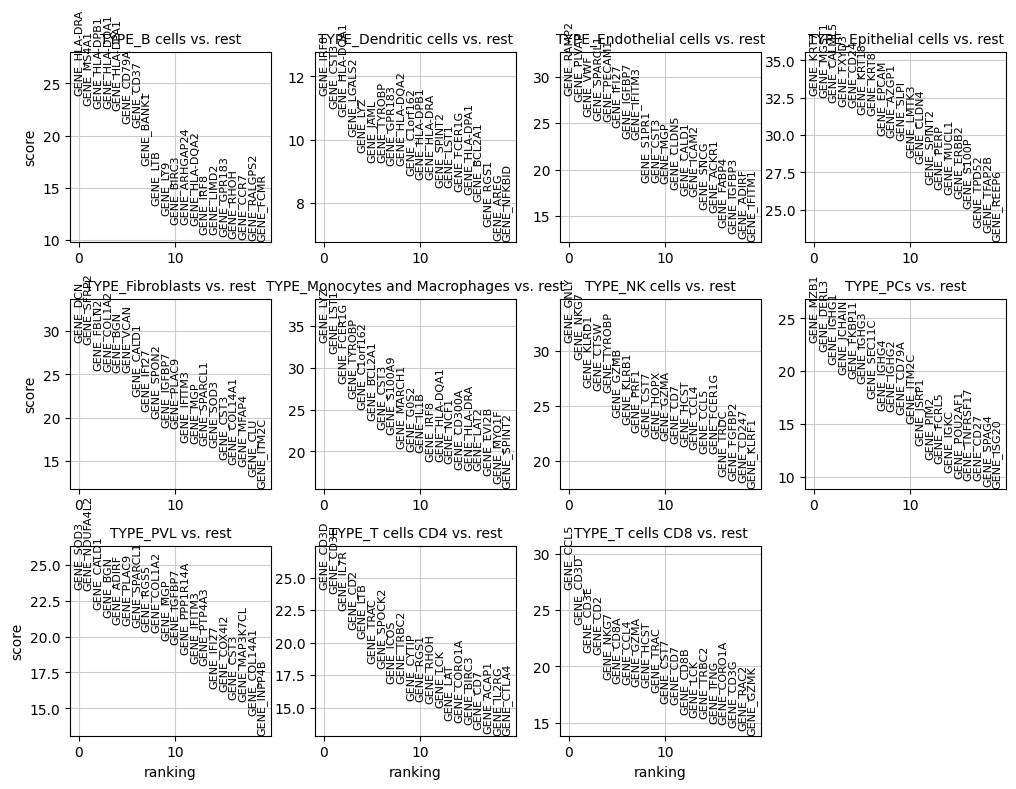

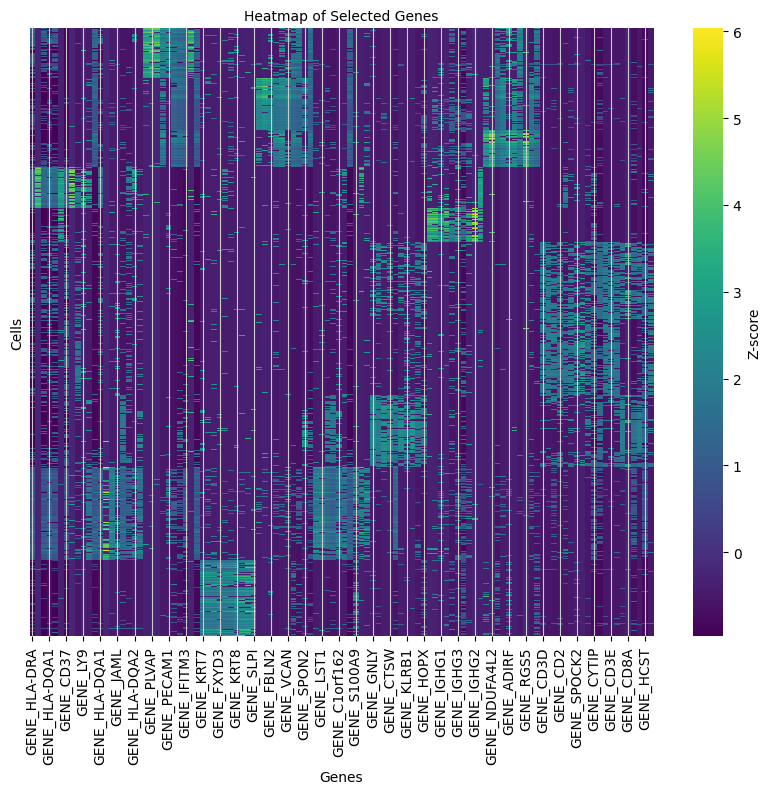

In [96]:
import scanpy as sc
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 加载数据
# 假设 scadata 是一个已加载的 AnnData 对象

# 数据预处理
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)
sc.pp.highly_variable_genes(sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc_adata = sc_adata[:, sc_adata.var.highly_variable]

# 差异表达分析
groupby = 'CellType'  # 假设你的细胞类型信息存储在 'CellType' 列
sc.tl.rank_genes_groups(sc_adata, groupby=groupby, method='wilcoxon')
sc.pl.rank_genes_groups(sc_adata, n_genes=20, sharey=False)

# 选择关键基因
result = sc_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 为每个群体选择前10个显著差异表达的基因
top_genes = {}
for group in groups:
    top_genes[group] = result['names'][group][:10]

# 将选择的基因放入一个列表
selected_genes = [gene for group in top_genes.values() for gene in group]

# 提取这些基因的表达数据
expr_data = pd.DataFrame(sc_adata.X, index=sc_adata.obs_names, columns=sc_adata.var_names)
expr_data_selected = expr_data[selected_genes]

# 对数据进行标准化处理
scaler = StandardScaler()
expr_data_scaled = scaler.fit_transform(expr_data_selected)
expr_data_scaled = pd.DataFrame(expr_data_scaled, index=expr_data_selected.index, columns=expr_data_selected.columns)

# 生成热图
plt.figure(figsize=(10, 8))
sns.heatmap(expr_data_scaled, cmap="viridis", yticklabels=False, cbar_kws={'label': 'Z-score'})
plt.title("Heatmap of Selected Genes")
plt.xlabel("Genes")
plt.ylabel("Cells")
plt.show()


In [33]:
scadata = sc.read_h5ad('/data/wzh/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

/opt/conda/envs/SPACEL/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


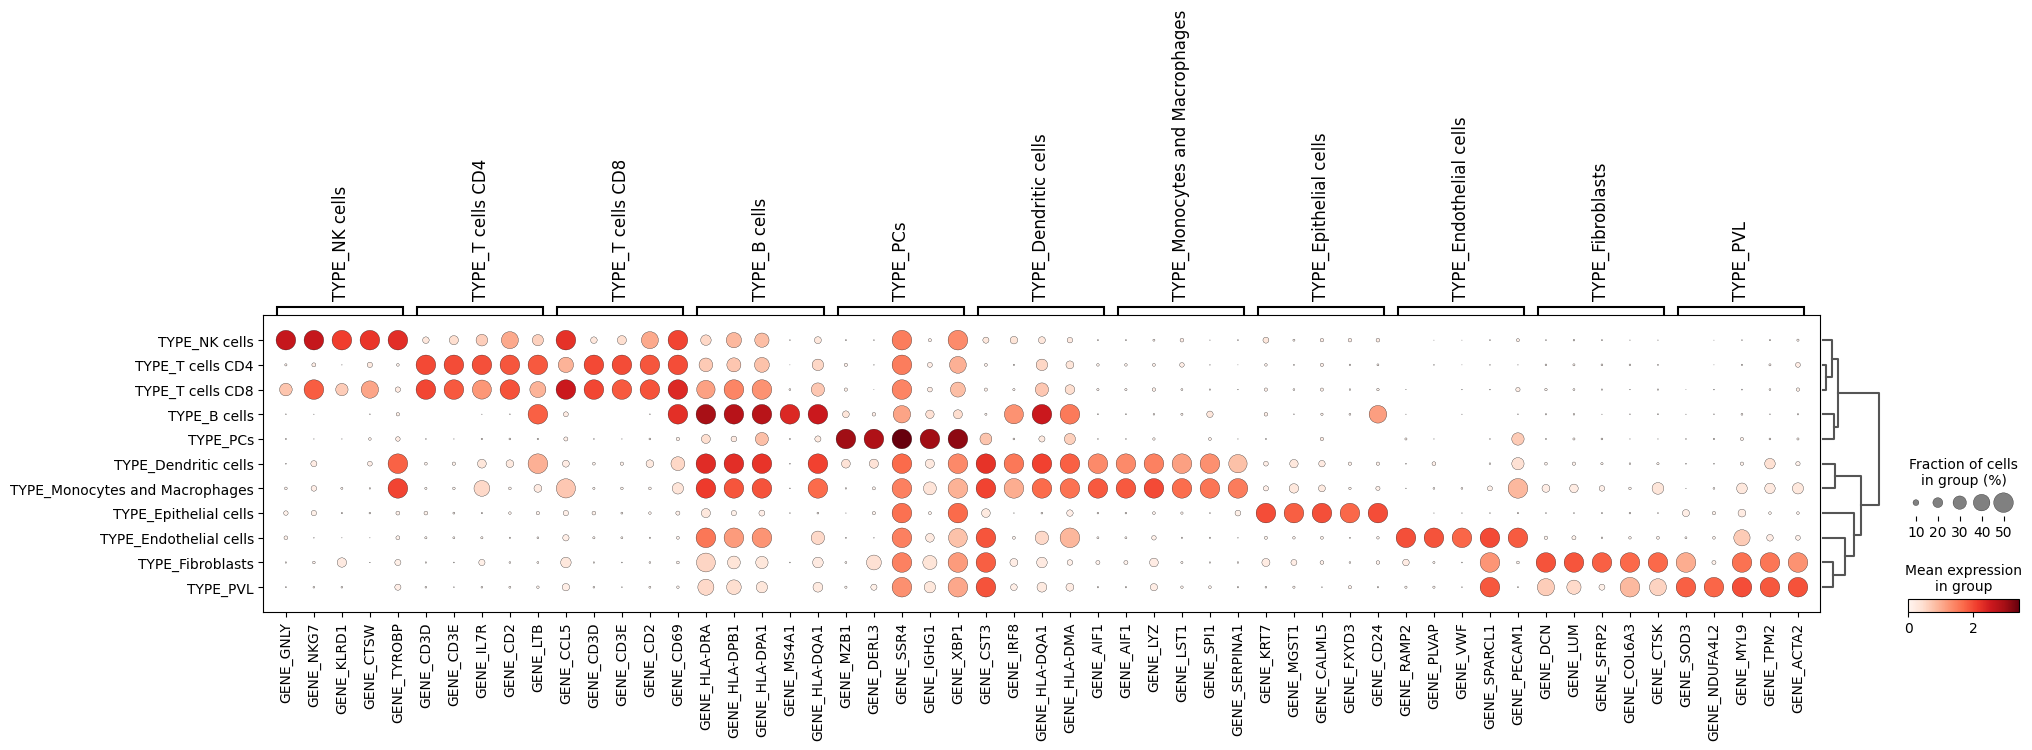

In [34]:
import scanpy as sc
import pandas as pd

# 加载数据
# 假设 scadata 是一个已加载的 AnnData 对象

# 数据预处理
sc.pp.normalize_total(scadata, target_sum=1e4)
sc.pp.log1p(scadata)
sc.pp.highly_variable_genes(scadata, min_mean=0.0125, max_mean=3, min_disp=0.5)
scadata = scadata[:, scadata.var.highly_variable]

# 差异表达分析
groupby = 'CellType'  # 假设你的细胞类型信息存储在 'CellType' 列
sc.tl.rank_genes_groups(scadata, groupby=groupby, method='wilcoxon')

# 选择关键基因
result = scadata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 为每个群体选择前10个显著差异表达的基因
top_genes = {}
for group in groups:
    top_genes[group] = result['names'][group][:5]

# 将选择的基因放入一个列表
selected_genes = [gene for group in top_genes.values() for gene in group]

# 确保选择的基因在数据中
selected_genes = [gene for gene in selected_genes if gene in scadata.var_names]

# 创建 marker_genes_dict
marker_genes_dict = {group: top_genes[group] for group in groups}

# 生成点图
# 生成点图，并调整字体大小和点的大小


# # 调整点的大小
# for artist in dotplot_dict['mainplot_ax'].collections:
#     artist.set_sizes([50])  # 设置点的大小

# # 调整字体大小
# for text in dotplot_dict['mainplot_ax'].texts:
#     text.set_fontsize(20)  # 设置字体大小
sc.pl.dotplot(scadata, marker_genes_dict, groupby=groupby, dendrogram=True, dot_max=0.5, var_group_positions={'var_group': 5.0})
plt.show()



In [15]:
sc_adata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')
sc_adata

AnnData object with n_obs × n_vars = 3977 × 15433
    obs: 'CellType'
    var: 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

/tmp/ipykernel_233854/287915837.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[cell_type], label=cell_type, shade=True)
/tmp/ipykernel_233854/287915837.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[cell_type], label=cell_type, shade=True)
/tmp/ipykernel_233854/287915837.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[cell_type], label=cell_type, shade=True)
/tmp/ipykernel_233854/287915837.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[cell_type], l

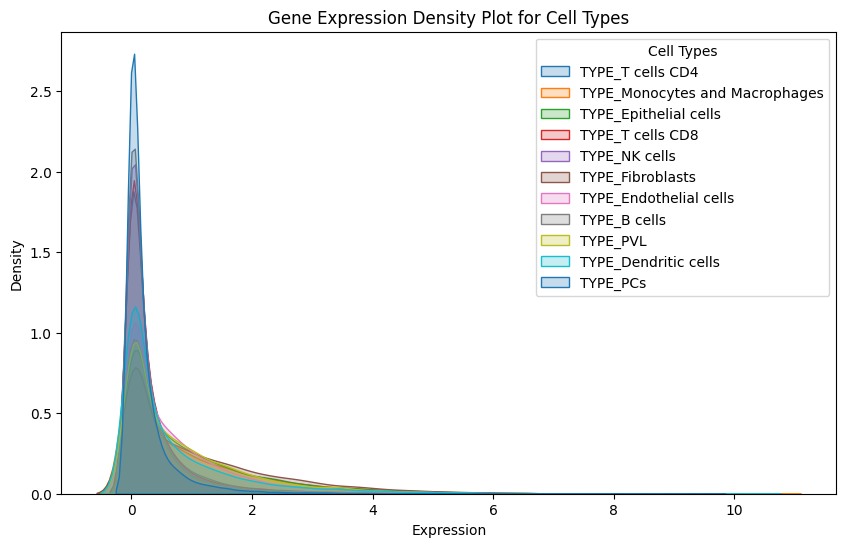

In [17]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 读取数据
scadata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

# 定义细胞类型
cell_types = [
    "TYPE_T cells CD4",
    "TYPE_Monocytes and Macrophages",
    "TYPE_Epithelial cells",
    "TYPE_T cells CD8",
    "TYPE_NK cells",
    "TYPE_Fibroblasts",
    "TYPE_Endothelial cells",
    "TYPE_B cells",
    "TYPE_PVL",
    "TYPE_Dendritic cells",
    "TYPE_PCs"
]

# 提取每个细胞类型的表达值
expression_data = {}
for cell_type in cell_types:
    cells = scadata.obs[scadata.obs['CellType'] == cell_type].index
    expression_data[cell_type] = scadata[cells, :].X.mean(axis=0)

# 将表达值转换为 DataFrame
df = pd.DataFrame(expression_data, index=scadata.var_names).T

# 绘制密度图
plt.figure(figsize=(10, 6))
for cell_type in cell_types:
    sns.kdeplot(df.loc[cell_type], label=cell_type, shade=True)

# 添加标签和标题
plt.xlabel('Expression')
plt.ylabel('Density')
plt.title('Gene Expression Density Plot for Cell Types')
plt.legend(title='Cell Types')
plt.show()


In [21]:
import scanpy as sc
import pandas as pd

# 读取数据
scadata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

# 定义细胞类型
cell_types = [
    "TYPE_T cells CD4",
    "TYPE_Monocytes and Macrophages",
    "TYPE_Epithelial cells",
    "TYPE_T cells CD8",
    "TYPE_NK cells",
    "TYPE_Fibroblasts",
    "TYPE_Endothelial cells",
    "TYPE_B cells",
    "TYPE_PVL",
    "TYPE_Dendritic cells",
    "TYPE_PCs"
]

# 提取每个细胞类型的表达值
expression_data = {}
for cell_type in cell_types:
    cells = scadata.obs[scadata.obs['CellType'] == cell_type].index
    expression_data[cell_type] = scadata[cells, :].X.toarray().mean(axis=0)  # 转换为稠密矩阵再求平均值

# 将表达值转换为 DataFrame，并转置
df = pd.DataFrame(expression_data, index=scadata.var_names).T

# 重命名行，将基因名称改为细胞类型名称
df.index = cell_types

# 保存为xls文件
df.to_excel('/data/SPACEL-l/docs/tutorials/gene_expression_data_corrected.xlsx', index=True, index_label='Cell Type')

# 输出示例
print(df.head())


                                GENE_FKBPL  GENE_ZNF317  GENE_GPR37L1  \
TYPE_T cells CD4                  0.156886     0.172424      0.000000   
TYPE_Monocytes and Macrophages    0.257047     0.580955      0.000000   
TYPE_Epithelial cells             1.106910     0.386590      0.008596   
TYPE_T cells CD8                  0.145343     0.277851      0.000000   
TYPE_NK cells                     0.157345     0.195687      0.000000   

                                GENE_ABI1  GENE_AP1S3  GENE_MXRA7  \
TYPE_T cells CD4                 1.513610    0.058224    0.188625   
TYPE_Monocytes and Macrophages   3.071812    0.090995    0.317773   
TYPE_Epithelial cells            2.402446    0.361512    0.040854   
TYPE_T cells CD8                 1.190392    0.070219    0.546246   
TYPE_NK cells                    1.147562    0.040717    0.453001   

                                GENE_METAP2  GENE_FAM155B  GENE_LIMCH1  \
TYPE_T cells CD4                   1.200539      0.000000     0.000000  

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


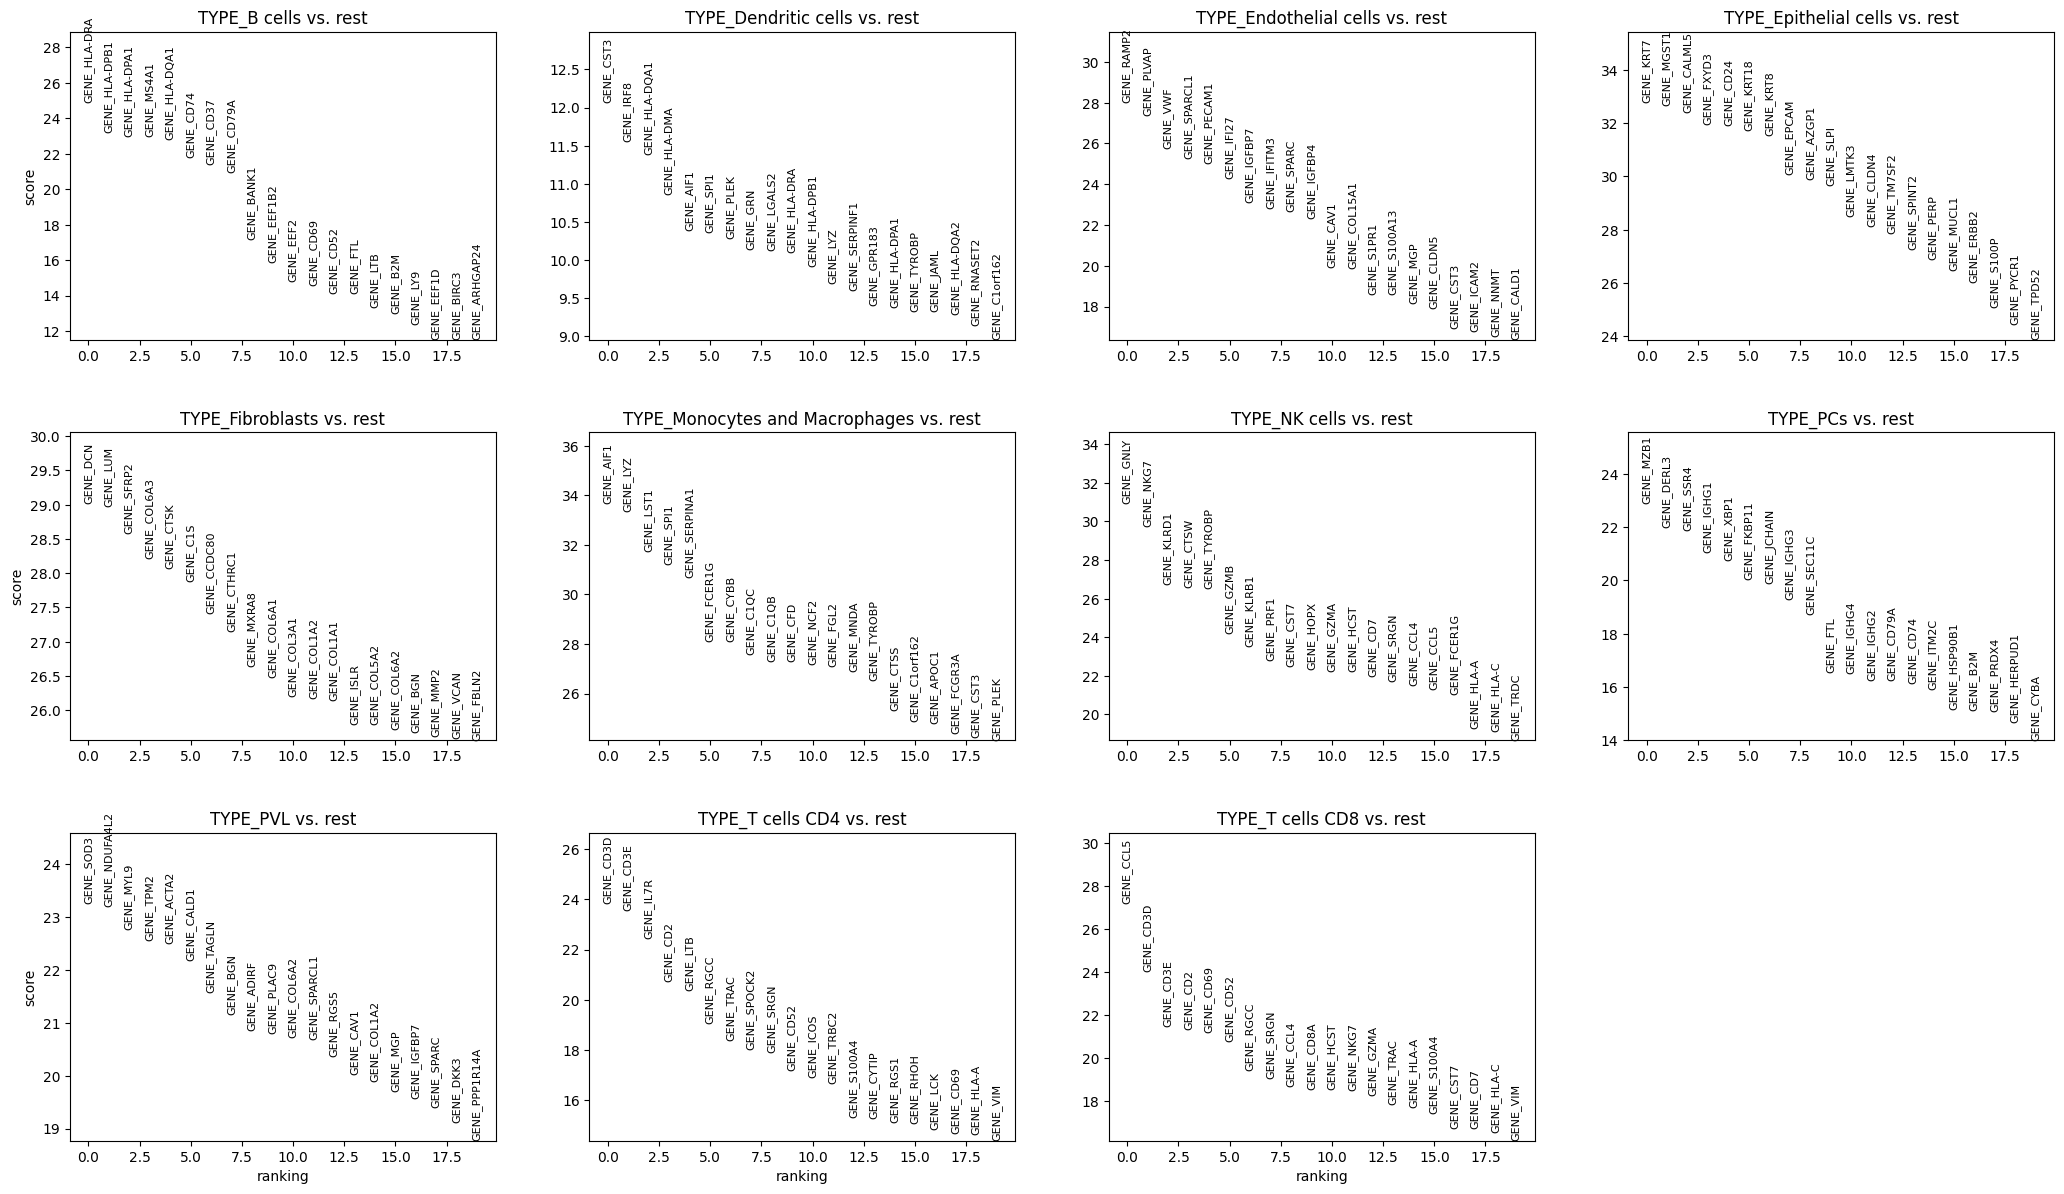

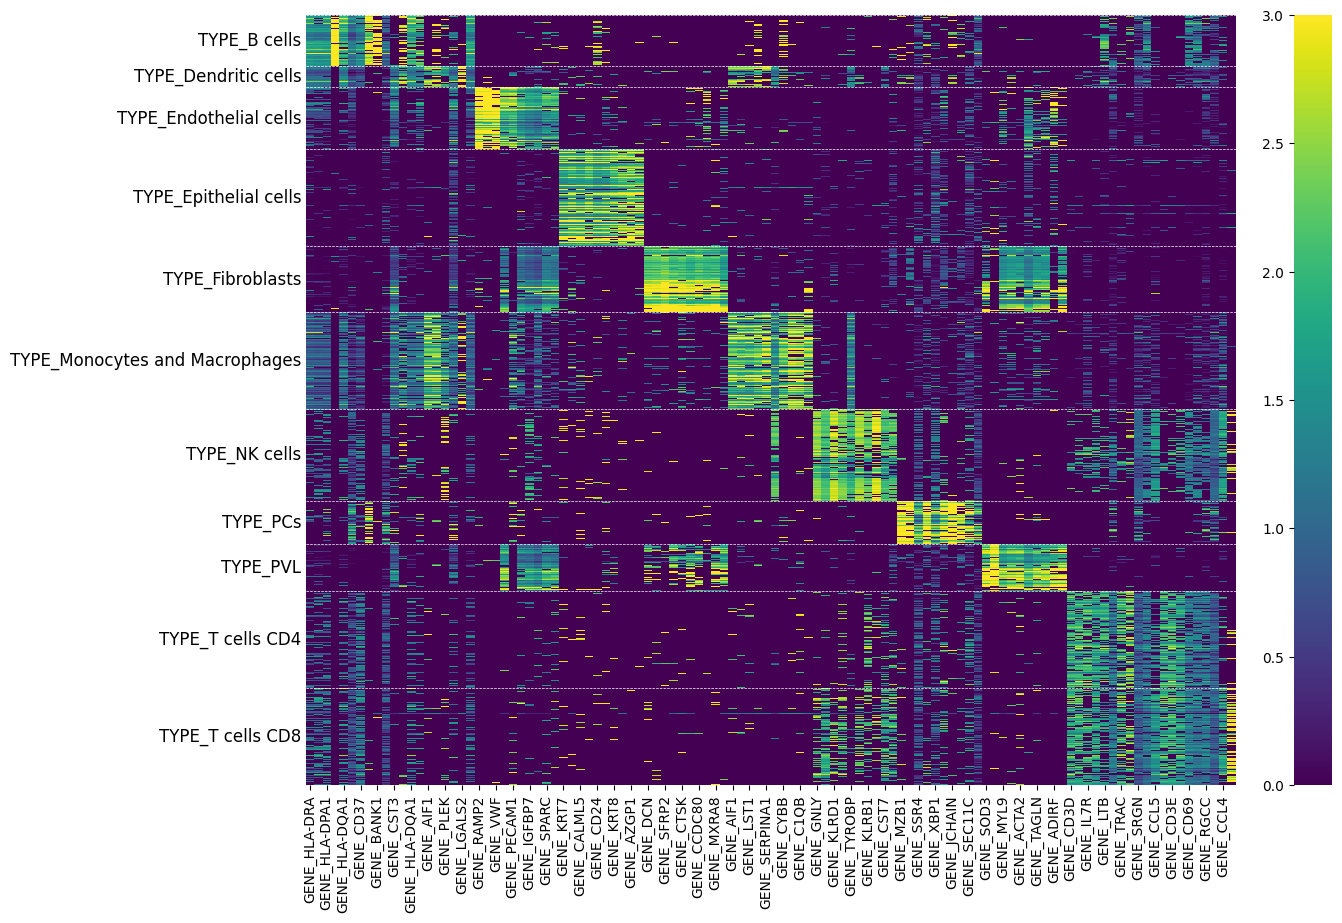

In [7]:
import scanpy as sc
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 加载数据
# 假设 sc_adata 是一个已加载的 AnnData 对象

# 数据预处理
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)
sc.pp.highly_variable_genes(sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc_adata = sc_adata[:, sc_adata.var.highly_variable]

# 差异表达分析
groupby = 'CellType'  # 假设你的细胞类型信息存储在 'CellType' 列
sc.tl.rank_genes_groups(sc_adata, groupby=groupby, method='wilcoxon')
sc.pl.rank_genes_groups(sc_adata, n_genes=20, sharey=False)

# 选择关键基因
result = sc_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 为每个群体选择前10个显著差异表达的基因
top_genes = {}
for group in groups:
    top_genes[group] = result['names'][group][:10]

# 将选择的基因放入一个列表
selected_genes = [gene for group in top_genes.values() for gene in group]

# 提取这些基因的表达数据
expr_data = pd.DataFrame(sc_adata.X, index=sc_adata.obs_names, columns=sc_adata.var_names)
expr_data_selected = expr_data[selected_genes]

# 获取细胞类型信息
cell_types = sc_adata.obs[groupby]

# 对数据进行标准化处理
scaler = StandardScaler()
expr_data_scaled = scaler.fit_transform(expr_data_selected)
expr_data_scaled = pd.DataFrame(expr_data_scaled, index=expr_data_selected.index, columns=expr_data_selected.columns)

# 将细胞类型信息添加到标准化数据中
expr_data_scaled['CellType'] = cell_types

# 按细胞类型排序
expr_data_scaled = expr_data_scaled.sort_values('CellType')

# 删除用于排序的细胞类型列
cell_type_order = expr_data_scaled['CellType']
expr_data_scaled = expr_data_scaled.drop(columns=['CellType'])

# 生成热图
plt.figure(figsize=(15, 10))

# 绘制热图并设置颜色条范围和位置
heatmap = sns.heatmap(expr_data_scaled, cmap="viridis", yticklabels=False, vmin=0, vmax=3, cbar=True)

# 获取颜色条对象并将其移动到左侧
cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')

# 设置热图的标题和轴标签
# plt.title("Heatmap of Selected Genes")
# plt.xlabel("Genes")
# plt.ylabel("Cells")

# 添加细胞类型的分区线和标签
unique_cell_types = cell_type_order.unique()
current_pos = 0
for cell_type in unique_cell_types:
    cell_count = cell_type_order[cell_type_order == cell_type].shape[0]
    plt.axhline(current_pos, color='white', linestyle='--', linewidth=0.5)  # 分割线变细
    plt.text(-0.5, current_pos + cell_count / 2, cell_type, verticalalignment='center', fontsize=12, color='black', ha='right')  # 注释放在热图左侧
    current_pos += cell_count

plt.show()


In [8]:
import pandas as pd

# 假设您已经有差异表达分析结果
result = sc_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 定义显著性的标准，例如p值和log fold change
pval_threshold = 0.05
logfoldchange_threshold = 1.5

# 创建一个空的DataFrame用于存储显著差异表达基因
significant_genes = pd.DataFrame()

for group in groups:
    # 提取该组别的基因名称、p值和log fold change
    gene_names = result['names'][group]
    pvals = result['pvals'][group]
    logfoldchanges = result['logfoldchanges'][group]
    
    # 创建DataFrame
    df = pd.DataFrame({
        'gene': gene_names,
        'pval': pvals,
        'logfoldchange': logfoldchanges
    })
    
    # 筛选显著差异表达基因
    significant = df[(df['pval'] < pval_threshold) & (abs(df['logfoldchange']) > logfoldchange_threshold)]
    
    # 添加group信息
    significant['group'] = group
    
    # 合并到总的DataFrame中
    significant_genes = pd.concat([significant_genes, significant], ignore_index=True)

# 移除基因名称中的 "GENE_" 前缀
significant_genes['gene'] = significant_genes['gene'].str.replace('GENE_', '')

# 输出显著差异表达基因
print(significant_genes)

# 将显著差异表达基因保存为xls文件
with pd.ExcelWriter('significant_genes1.xlsx') as writer:
    significant_genes.to_excel(writer, index=False, sheet_name='Significant Genes1')


/tmp/ipykernel_233854/4137352924.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant['group'] = group
/tmp/ipykernel_233854/4137352924.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant['group'] = group
/tmp/ipykernel_233854/4137352924.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

          gene           pval  logfoldchange             group
0      HLA-DRA  1.926004e-136       3.536232      TYPE_B cells
1     HLA-DPB1  3.563707e-119       3.347185      TYPE_B cells
2     HLA-DPA1  8.653188e-117       3.296287      TYPE_B cells
3        MS4A1  1.520515e-116       9.323419      TYPE_B cells
4     HLA-DQA1  2.699659e-115       3.897779      TYPE_B cells
...        ...            ...            ...               ...
7010     PRDX4   9.687085e-39      -2.834907  TYPE_T cells CD8
7011    IFITM3   6.814177e-45      -3.226552  TYPE_T cells CD8
7012       GRN   4.806856e-51      -2.997940  TYPE_T cells CD8
7013      CST3   4.650812e-56      -4.011993  TYPE_T cells CD8
7014      NPC2   1.978154e-58      -2.790207  TYPE_T cells CD8

[7015 rows x 4 columns]


In [28]:
sc_adata

AnnData object with n_obs × n_vars = 3977 × 3875
    obs: 'CellType'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg', 'rank_genes_groups', 'CellType_colors', 'dendrogram_CellType'
    obsm: 'X_pca'
    varm: 'PCs'

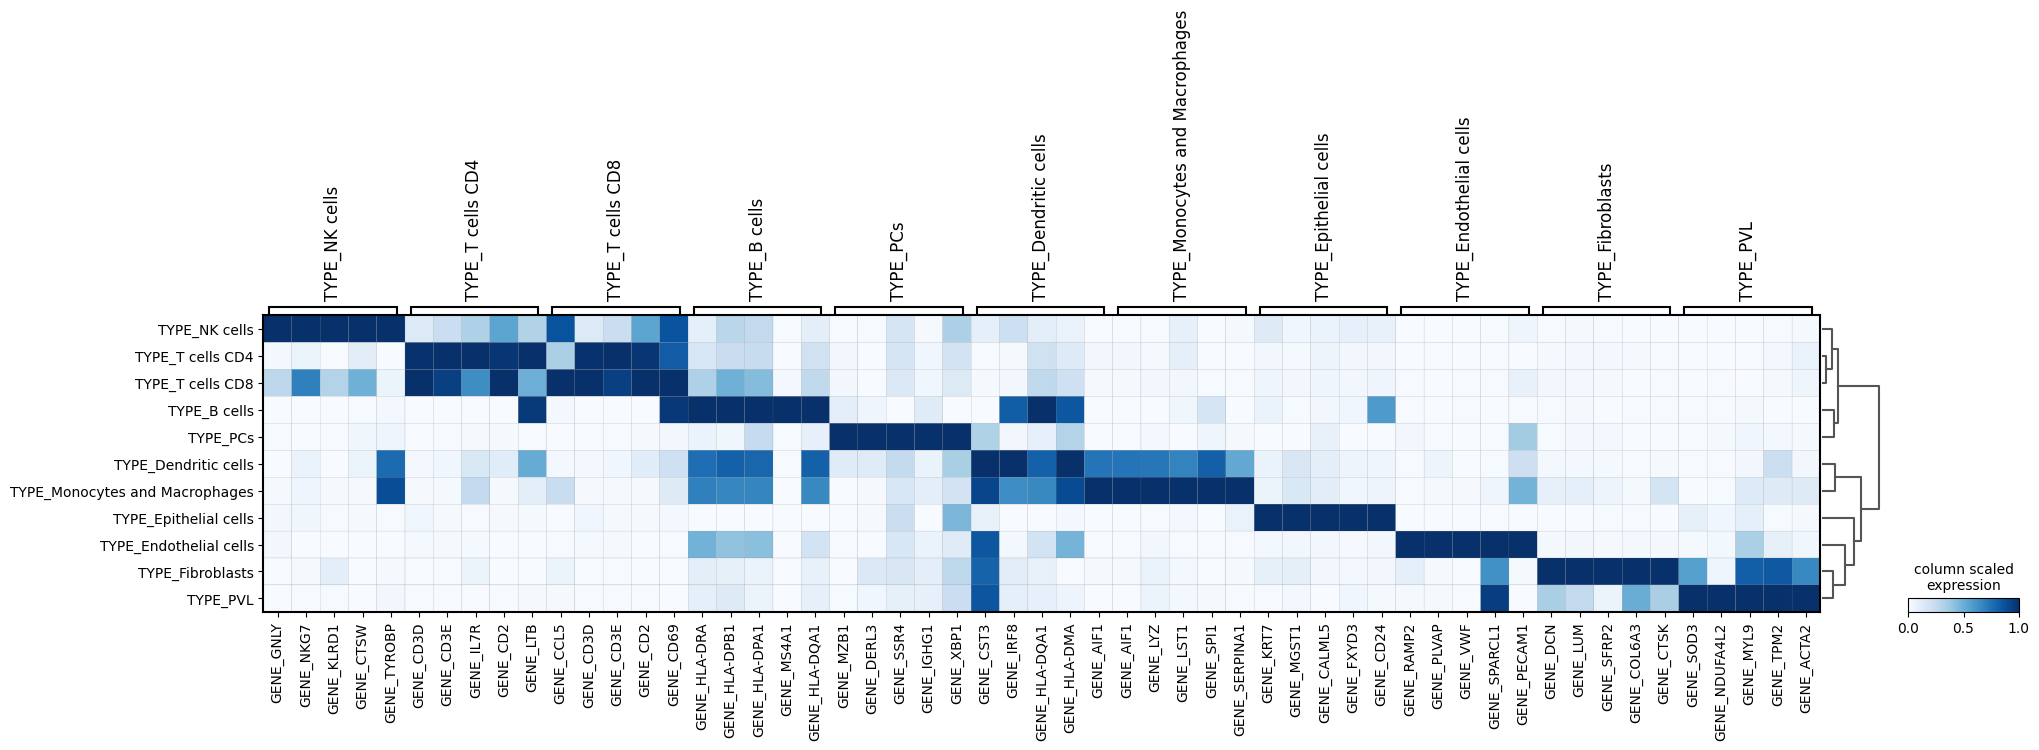

In [35]:
sc.pl.matrixplot(
    scadata,
    marker_genes_dict,
    "CellType",
    dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

In [36]:
# scale and store results in layer
scadata.layers["scaled"] = sc.pp.scale(scadata, copy=True).X

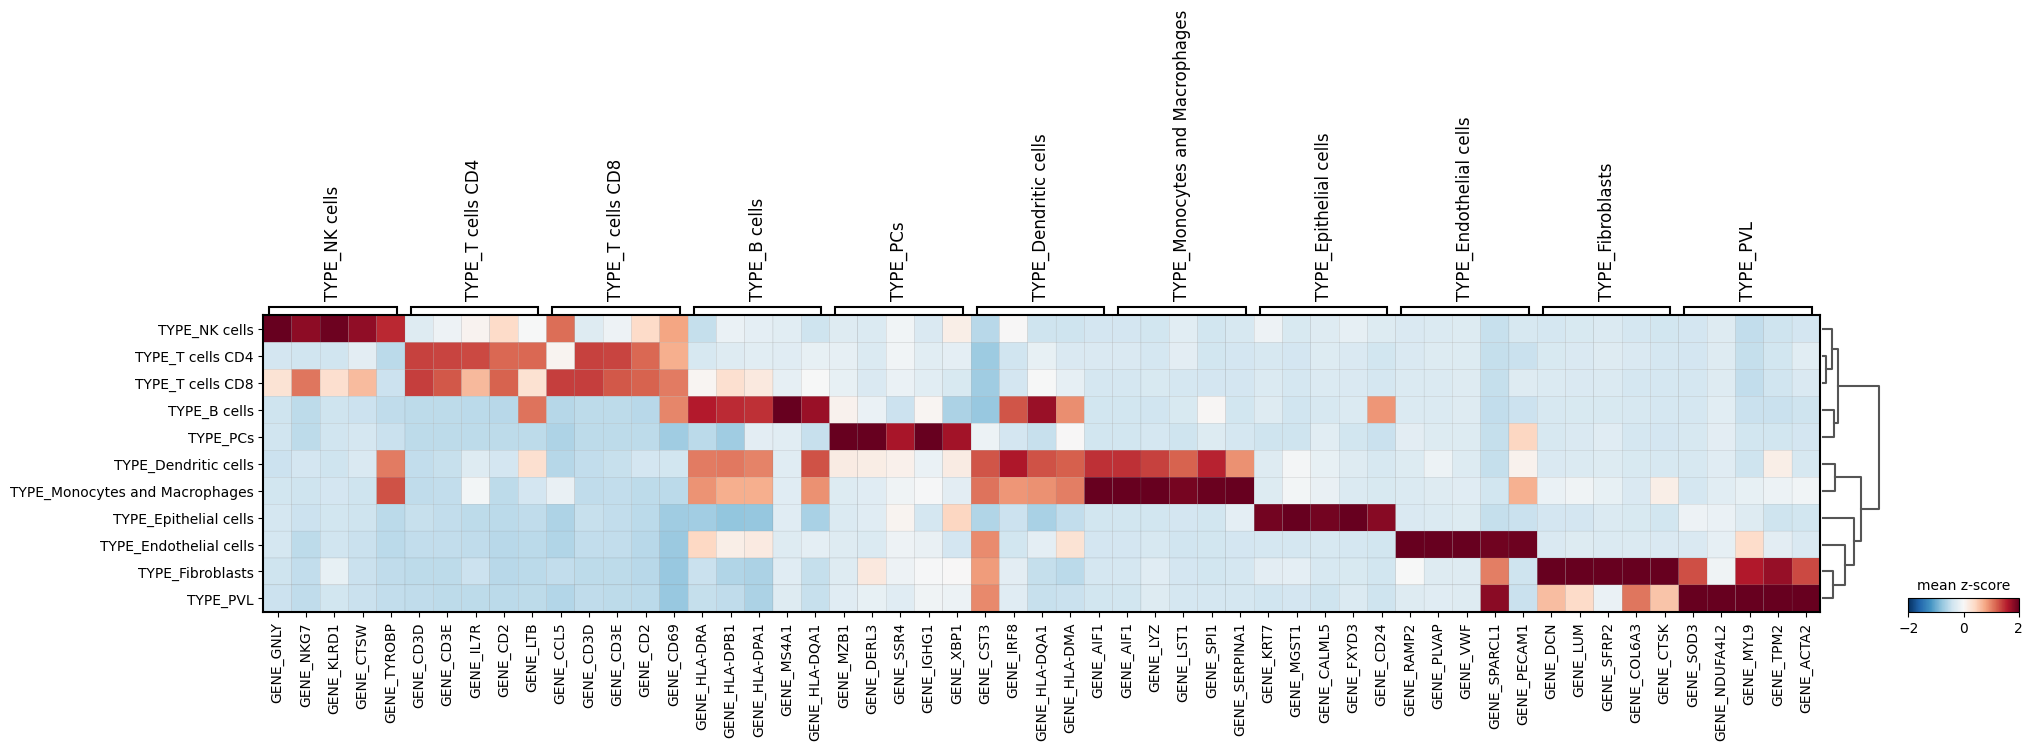

In [37]:
sc.pl.matrixplot(
    scadata,
    marker_genes_dict,
    "CellType",
    dendrogram=True,
    colorbar_title="mean z-score",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
)

In [42]:
sc.tl.leiden(
    scadata,
    key_added="clusters",
    resolution=0.5,
    n_iterations=2,
    flavor="igraph",
    directed=False,
)

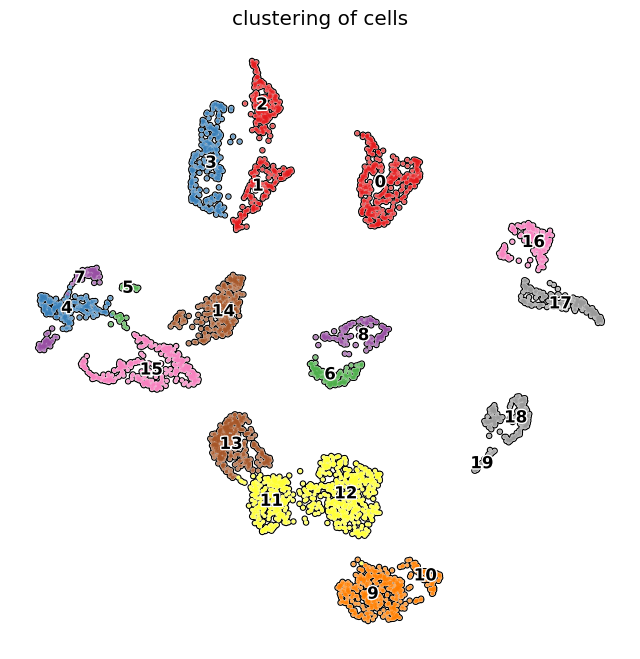

In [43]:
import matplotlib.pyplot as plt
from matplotlib import rc_context
with rc_context({"figure.figsize": (8, 8)}):
    sc.pl.umap(
        scadata,
        color="clusters",
        add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
        palette="Set1",
    )

categories: 0, 1, 2, etc.
var_group_labels: TYPE_B cells, TYPE_Dendritic cells, TYPE_Endothelial cells, etc.


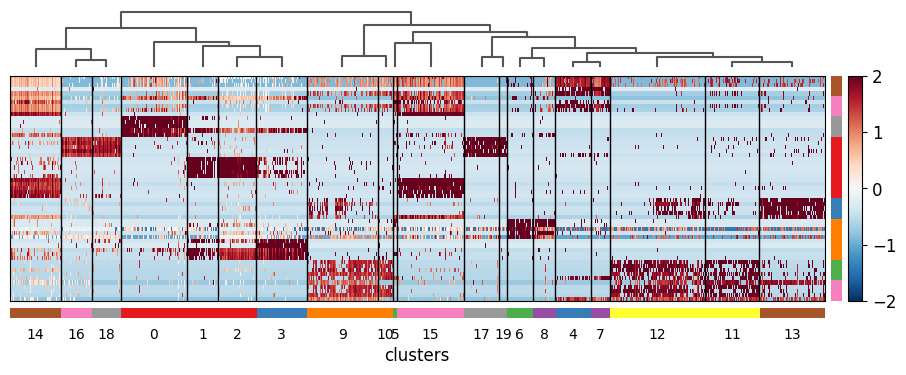

In [44]:
ax = sc.pl.heatmap(
    scadata,
    marker_genes_dict,
    groupby="clusters",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    dendrogram=True,
    swap_axes=True,
    figsize=(11, 4),
)

In [46]:
scadata

AnnData object with n_obs × n_vars = 3977 × 3875
    obs: 'CellType', 'clusters'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg', 'rank_genes_groups', 'dendrogram_CellType', 'neighbors', 'umap', 'CellType_colors', 'clusters', 'clusters_colors', 'dendrogram_clusters'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'distances', 'connectivities'

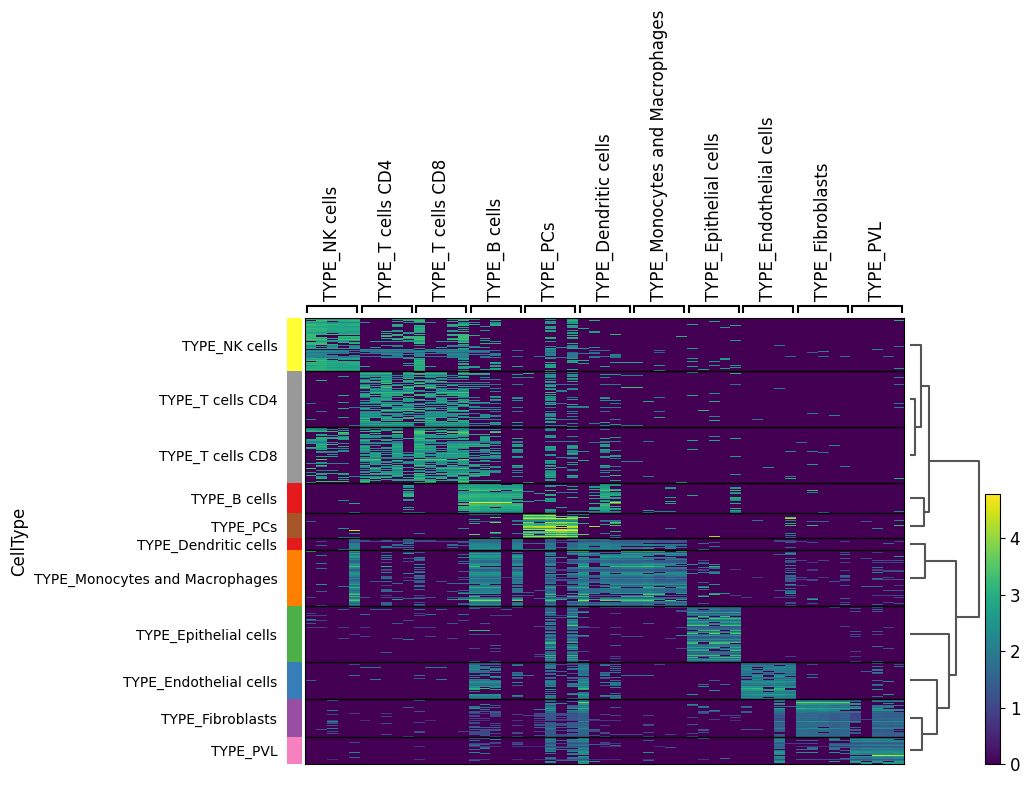

In [47]:
ax = sc.pl.heatmap(
    scadata, marker_genes_dict, groupby="CellType", cmap="viridis", dendrogram=True
)

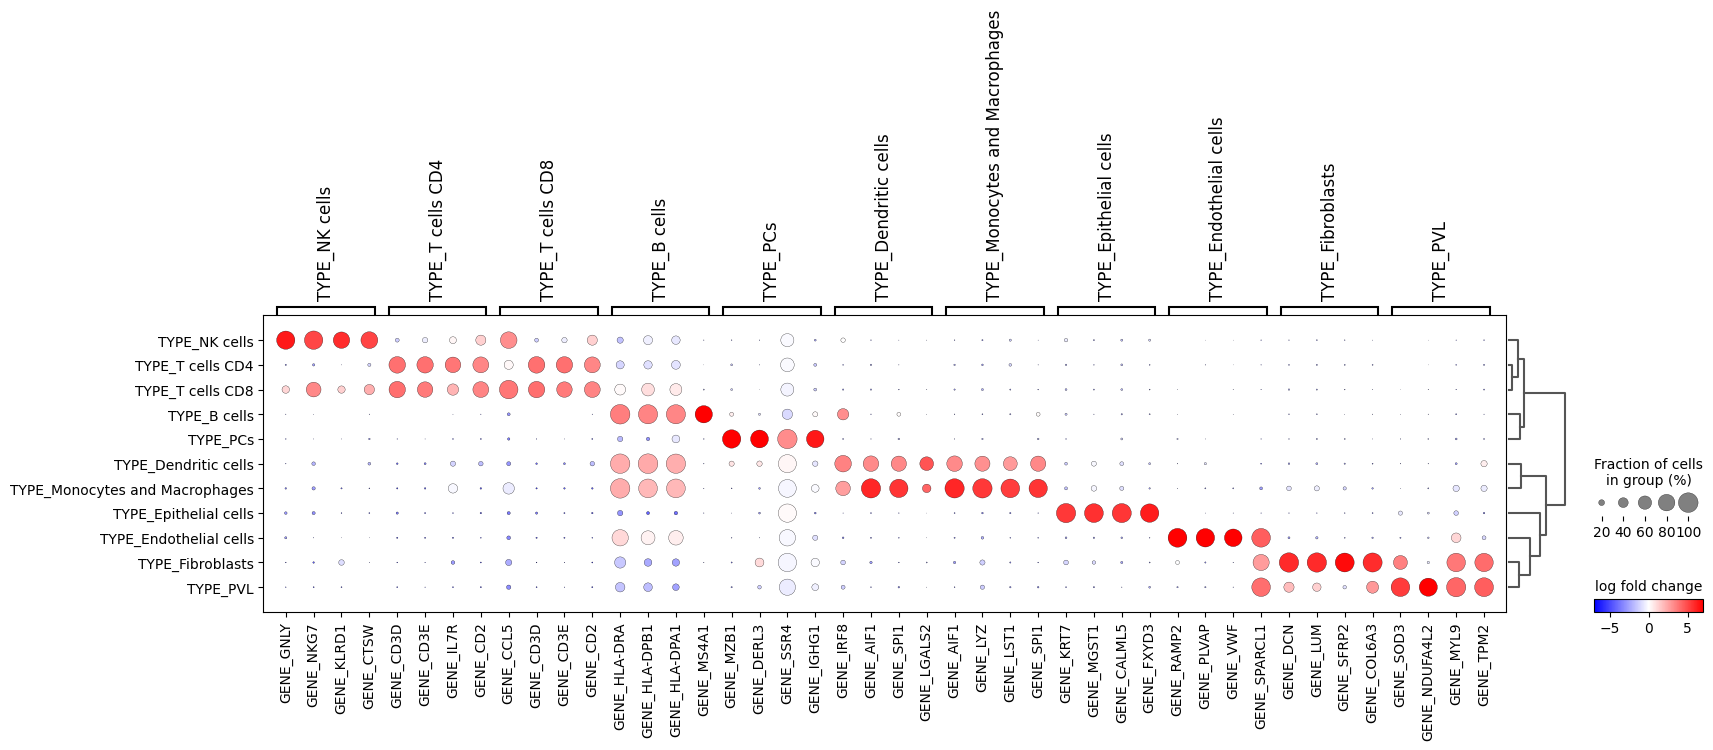

In [48]:
sc.pl.rank_genes_groups_dotplot(
    scadata,
    n_genes=4,
    values_to_plot="logfoldchanges",
    min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap="bwr",
)

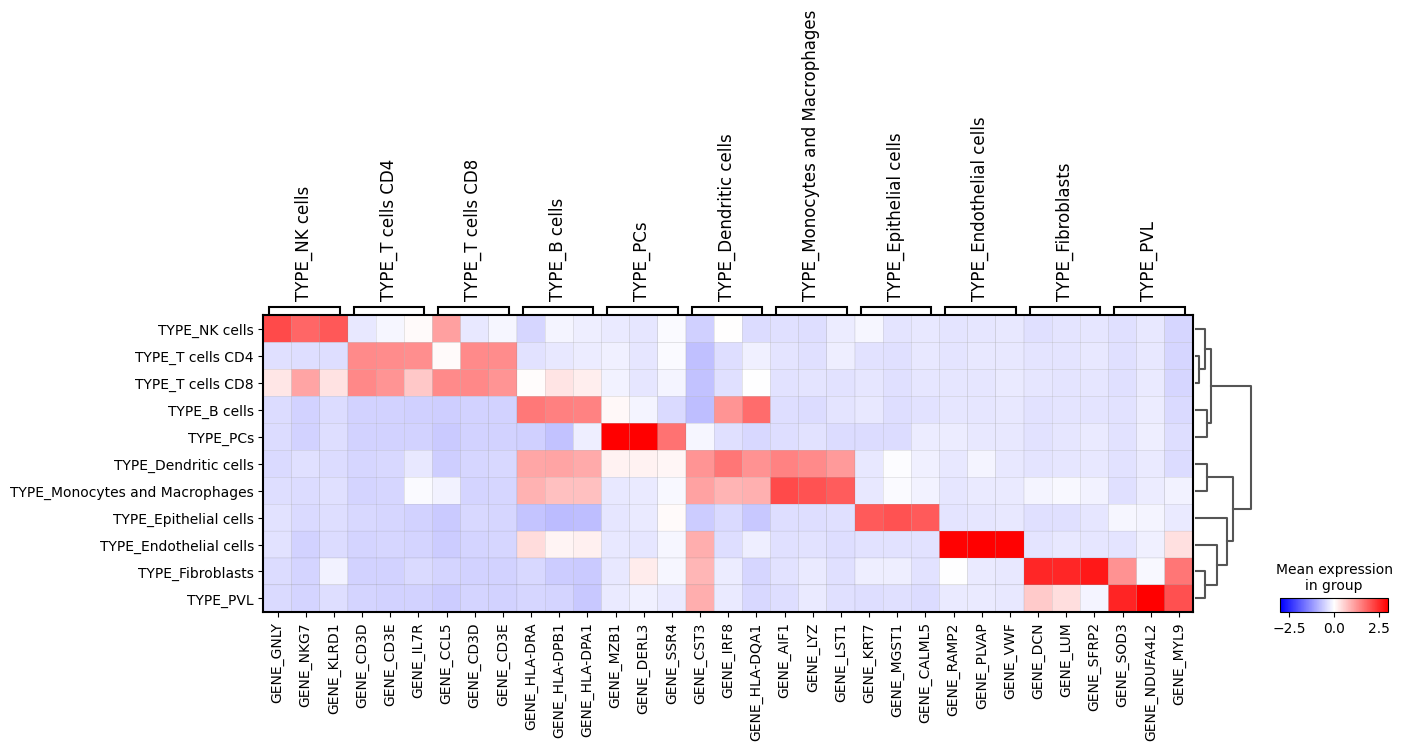

In [49]:
sc.pl.rank_genes_groups_matrixplot(
    scadata, n_genes=3, use_raw=False, vmin=-3, vmax=3, cmap="bwr", layer="scaled"
)

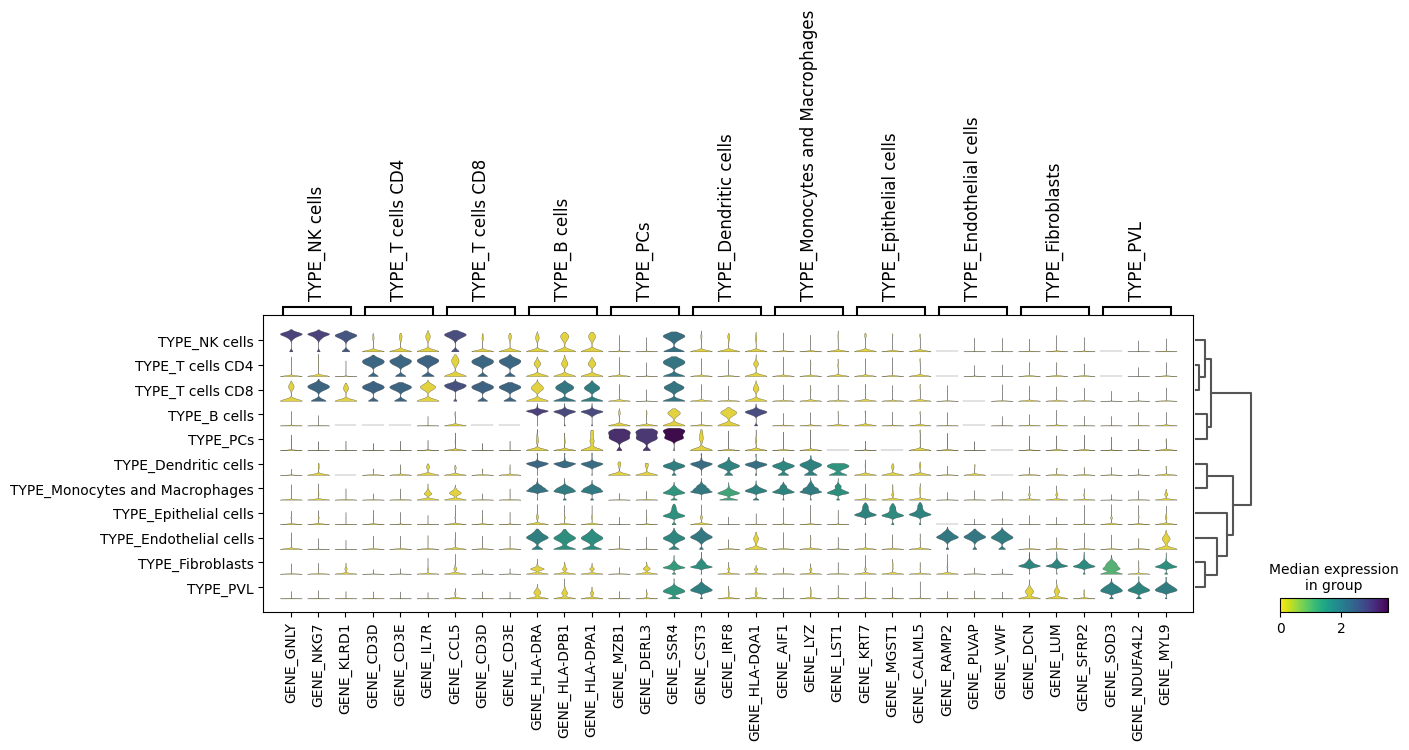

In [50]:
sc.pl.rank_genes_groups_stacked_violin(scadata, n_genes=3, cmap="viridis_r")

In [175]:
scadata

AnnData object with n_obs × n_vars = 3977 × 3875
    obs: 'CellType'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg', 'rank_genes_groups', 'dendrogram_CellType'
    obsm: 'X_pca'
    varm: 'PCs'

In [185]:
scadata

AnnData object with n_obs × n_vars = 3977 × 3875
    obs: 'CellType', 'clusters'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg', 'rank_genes_groups', 'dendrogram_CellType', 'neighbors', 'umap', 'CellType_colors', 'clusters', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [188]:
scadata.obs

CellType clusters
CELL_CID3921_AAAGATGGTGAGGCTA   TYPE_Endothelial cells        0
CELL_CID3921_AAAGATGTCCATGAGT   TYPE_Endothelial cells        0
CELL_CID3921_AACCATGCAGTAACGG   TYPE_Endothelial cells        0
CELL_CID3921_AACCGCGGTCAGAATA   TYPE_Endothelial cells        0
CELL_CID3921_AACGTTGTCAGCTGGC   TYPE_Endothelial cells        0
...                                                ...      ...
CELL_CID45171_CTGCTGTTCCTTTCGG   TYPE_Epithelial cells       17
CELL_CID3921_TCTTTCCTCCGAACGC    TYPE_Epithelial cells       18
CELL_CID45171_TATTACCTCGACCAGC   TYPE_Epithelial cells       16
CELL_CID3921_CTCATTATCTGTCTAT    TYPE_Epithelial cells       18
CELL_CID3921_GATCGTACACAGATTC    TYPE_Epithelial cells       18

[3977 rows x 2 columns]

In [189]:
import scanpy as sc

# 将 DataFrame 转换为 AnnData 对象
scadata_adata = sc.AnnData(scadata)

# 然后再调用 sc.pl.matrixplot 函数
sc.pl.matrixplot(
    scadata,
    var_names=cell_types,  # 行和列的变量名称
    groupby='clusters',  # 分组变量
    cmap="Blues",  # 颜色映射
    standard_scale="var",  # 数据标准化的方法
    colorbar_title="Counts",  # 颜色条标题
    dendrogram=True,  # 绘制树状图
)


KeyError: "Could not find keys '['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']' in columns of `adata.obs` or in adata.var_names."

In [10]:
scadata = sc.read_h5ad('/data/wzh/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

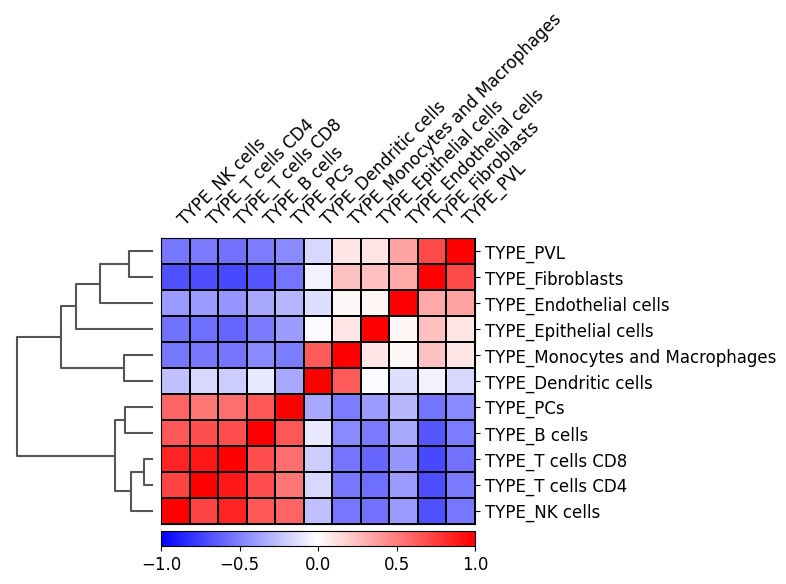

In [8]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据
# 假设 scadata 是一个已加载的 AnnData 对象

# 设置字体大小
plt.rcParams.update({'font.size': 12})

# 计算细胞类型之间的相关性矩阵
sc.pl.correlation_matrix(scadata, groupby='CellType', figsize=(6, 4))

plt.show()


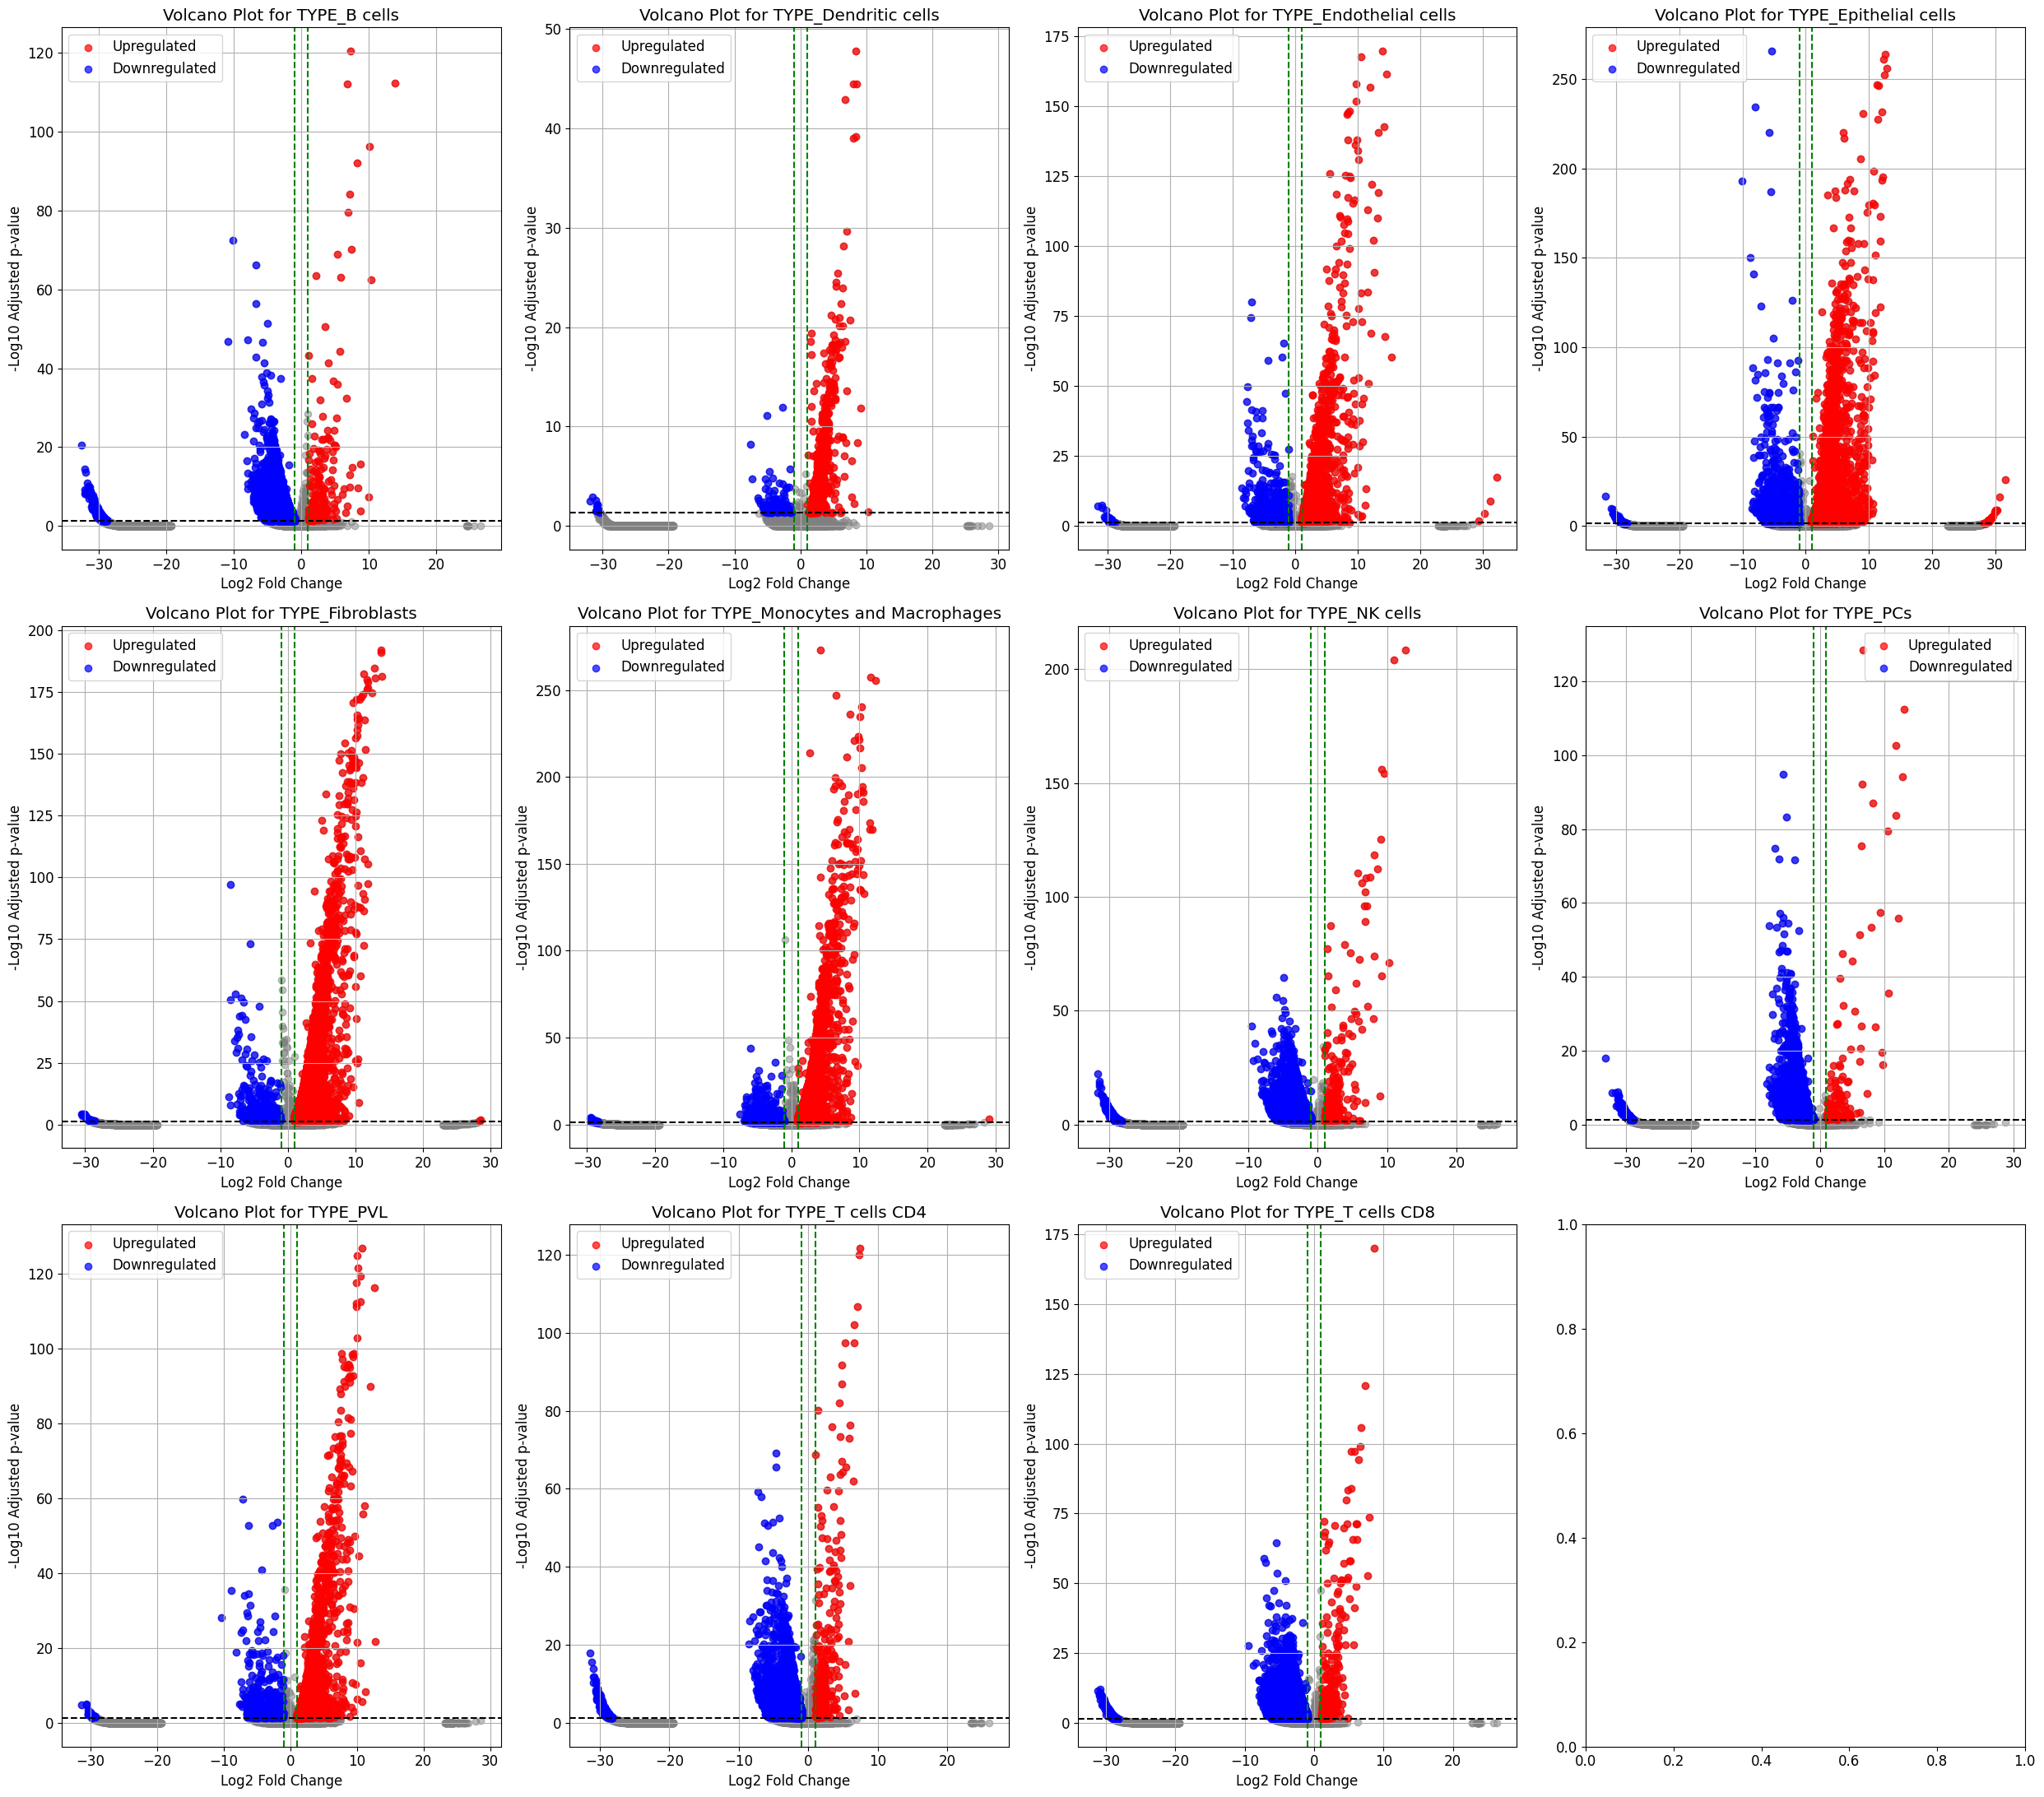

In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# 加载数据
# 假设 scadata 是一个已加载的 AnnData 对象

# 差异表达分析
groupby = 'CellType'  # 假设你的细胞类型信息存储在 'CellType' 列
sc.tl.rank_genes_groups(scadata, groupby=groupby, method='wilcoxon')

# 提取差异表达结果
result = scadata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 设置子图的行列数，根据细胞类型的数量来确定
num_groups = len(groups)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, num_groups * 2))

# 遍历每个细胞类型并绘制火山图
for i, cell_type in enumerate(groups):
    ax = axes.flat[i]

    logfoldchanges = result['logfoldchanges'][cell_type]
    pvals = result['pvals'][cell_type]

    # 进行多重检验校正
    _, adj_pvals, _, _ = multipletests(pvals, method='fdr_bh')

    # 转换为 -log10(p-value)
    neg_log10_pvals = -np.log10(adj_pvals)

    # 绘制火山图
    ax.scatter(logfoldchanges, neg_log10_pvals, c='gray', alpha=0.5)

    # 标记显著差异表达的基因
    significant_up = (adj_pvals < 0.05) & (logfoldchanges > 1)
    significant_down = (adj_pvals < 0.05) & (logfoldchanges < -1)

    ax.scatter(logfoldchanges[significant_up], neg_log10_pvals[significant_up], c='red', alpha=0.7, label='Upregulated')
    ax.scatter(logfoldchanges[significant_down], neg_log10_pvals[significant_down], c='blue', alpha=0.7, label='Downregulated')

    # 添加注释和网格线
    ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')  # 显著性阈值线
    ax.axvline(x=1, color='green', linestyle='--')  # 上调阈值线
    ax.axvline(x=-1, color='green', linestyle='--')  # 下调阈值线

    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 Adjusted p-value')
    ax.set_title(f'Volcano Plot for {cell_type}')
    ax.legend()
    ax.grid(True)

# 调整子图布局
plt.tight_layout()
plt.show()


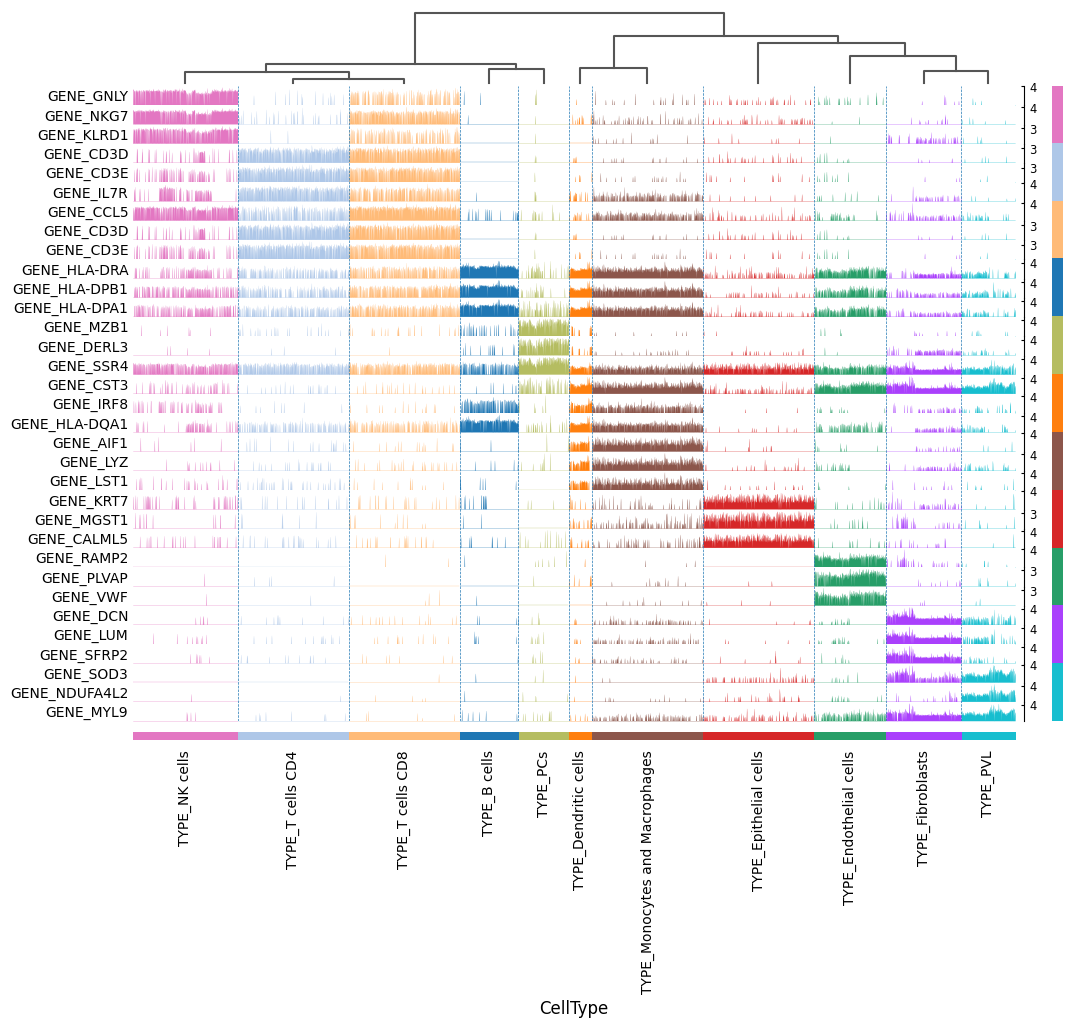

In [15]:
sc.pl.rank_genes_groups_tracksplot(sc_adata, n_genes=3)

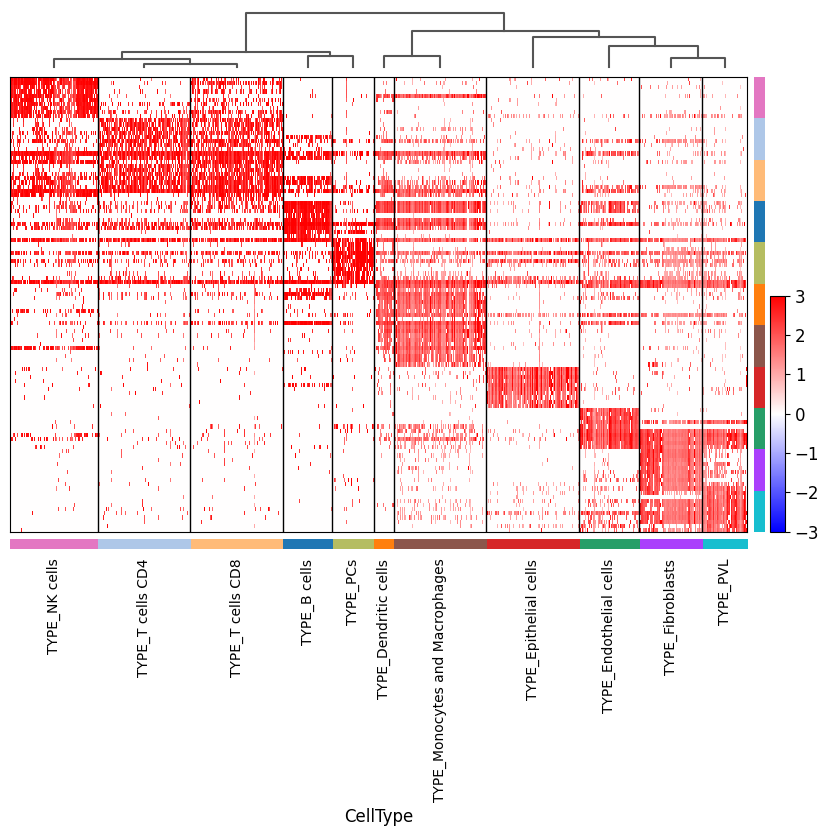

In [19]:
sc.pl.rank_genes_groups_heatmap(
    sc_adata,
    n_genes=10,
    use_raw=False,
    swap_axes=True,
    show_gene_labels=False,
    vmin=-3,
    vmax=3,
    cmap="bwr",
    figsize=(10, 7)
)